# Legal Contract Clause Classification

## Team Members
- Khaja Moinuddin Mohammed
- Venkat Saketh Kommi
- Sowmya Polagoni

## Project Overview
Classifying legal contract clauses using Feedforward and LSTM Neural Models


## 1. Import Necessary Libraries


In [1]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Create folders for outputs
os.makedirs('Visualizations', exist_ok=True)
os.makedirs('Models', exist_ok=True)

np.random.seed(42)
tf.random.set_seed(42)

## 2. Download and Load CUAD Dataset

The actual download/extract logic lives in `scripts/download_cuad.py` (run once via `python scripts/download_cuad.py`). This cell ensures the data is present and sets `cuad_path` and `data_path` for the rest of the notebook.


In [2]:
# Ensure CUAD dataset is present (run once; or run from terminal: python scripts/download_cuad.py)
import sys
sys.path.insert(0, str(Path.cwd()))
from scripts.download_cuad import ensure_cuad_data

cuad_path, data_path = ensure_cuad_data()
print(f"\nUsing dataset at: {data_path.absolute()}")

CUAD dataset directory already exists.

Dataset found at: /Users/khajamoinuddinmohammed/Documents/MSDS/FALL 2025/BUAN 5312 ADVANCED ML/final project/cuad/data

Contents of data directory:
   CUADv1.json
   test.json
   train_separate_questions.json

Using dataset at: /Users/khajamoinuddinmohammed/Documents/MSDS/FALL 2025/BUAN 5312 ADVANCED ML/final project/cuad/data


## 3. Read Category Descriptions

First, let's understand what categories/clauses we'll be working with by reading the category descriptions file.


In [26]:
category_desc_path = cuad_path / "category_descriptions.csv"

if category_desc_path.exists():
    category_df = pd.read_csv(category_desc_path)

    
    print("\nCUAD CATEGORY DESCRIPTIONS")
    print(f"\nTotal categories: {len(category_df)}")
    print(f"\nColumns: {list(category_df.columns)}")

    if 'Category (incl. context and answer)' in category_df.columns:
        category_df['Category'] = category_df['Category (incl. context and answer)'].str.replace('Category: ', '')

    
    print("\n CATEGORY LIST:")
    
    for idx, row in category_df.iterrows():
        cat_name = row.get('Category', row.get('Category (incl. context and answer)', 'Unknown'))
        desc = row.get('Description', 'No description')
        answer_format = row.get('Answer Format', 'N/A')
        group = row.get('Group', '-')

        print(f"\n{idx + 1}. {cat_name}")
        print(f"   Description: {desc}")
        print(f"   Answer Format: {answer_format}")
        if pd.notna(group) and group != '-':
            print(f"   Group: {group}")

    
    print("\nCATEGORY SUMMARY BY GROUP:")
    if 'Group' in category_df.columns:
        group_counts = category_df['Group'].value_counts().sort_index()
        for group, count in group_counts.items():
            if pd.notna(group) and group != '-':
                print(f"Group {group}: {count} categories")
        if '-' in group_counts.index:
            print(f"Ungrouped: {group_counts.get('-', 0)} categories")

    
    print("\nCATEGORY DATAFRAME (first 10 rows):")
    display_cols = [col for col in category_df.columns if 'Category' in col or col == 'Description']
    print(category_df[display_cols].head(10).to_string())

else:
    print(f"[WARNING]  Category descriptions file not found at {category_desc_path}")

if category_desc_path.exists():
    if 'Category (incl. context and answer)' in category_df.columns:
        category_names = category_df['Category (incl. context and answer)'].str.replace('Category: ', '').tolist()
    else:
        category_names = category_df.iloc[:, 0].str.replace('Category: ', '').tolist()
    print(f"\n[OK] Found {len(category_names)} categories for classification")


CUAD CATEGORY DESCRIPTIONS

Total categories: 41

Columns: ['Category (incl. context and answer)', 'Description', 'Answer Format', 'Group']

 CATEGORY LIST:

1. Document Name
   Description: Description: The name of the contract
   Answer Format: Answer Format: Contract Name
   Group: Group: -

2. Parties
   Description: Description: The two or more parties who signed the contract
   Answer Format: Answer Format: Entity or individual names
   Group: Group: -

3. Agreement Date
   Description: Description: The date of the contract
   Answer Format: Answer Format: Date (mm/dd/yyyy)
   Group: Group: 1

4. Effective Date
   Description: Description: The date when the contract is effective 
   Answer Format: Answer Format: Date (mm/dd/yyyy)
   Group: Group: 1

5. Expiration Date
   Description: Description: On what date will the contract's initial term expire?
   Answer Format: Answer Format: Date (mm/dd/yyyy) / Perpetual
   Group: Group: 1

6. Renewal Term
   Description: Description: Wha

## 4. Exploratory Data Analysis (EDA) on CUADv1 Dataset

We'll use **CUADv1.json** as our complete dataset. Let's perform comprehensive EDA to understand:
- Clause category distribution and class balance
- Text length statistics (for sequence padding decisions)
- Clauses per contract distribution
- Category-specific text characteristics
- Data quality checks


In [27]:

print("EXTRACTING CLAUSES FROM CUADv1.json")


def extract_clauses_from_cuadv1(json_filepath):
    """
    Extract all clauses (answer spans) with their categories from CUADv1.json.
    Returns a DataFrame with columns: contract_id, clause_text, category, answer_start, answer_end
    """
    clauses = []

    with open(json_filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)

    if 'data' not in data:
        print("[WARNING]  No 'data' key found in JSON file")
        return pd.DataFrame()

    contracts = data['data']
    print(f"Processing {len(contracts)} contracts...")

    for contract in contracts:
        contract_id = contract.get('title', 'unknown')

        if 'paragraphs' not in contract:
            continue

        for para in contract['paragraphs']:
            context = para.get('context', '')

            if 'qas' not in para:
                continue

            for qa in para['qas']:
                question = qa.get('question', '')

                category = None
                if 'related to "' in question:
                    category = question.split('related to "')[1].split('"')[0]

                if not category:
                    continue

                answers = qa.get('answers', [])
                is_impossible = qa.get('is_impossible', False)

                if not is_impossible and answers:
                    for answer in answers:
                        answer_text = answer.get('text', '').strip()
                        answer_start = answer.get('answer_start', None)

                        if answer_text:
                            clauses.append({
                                'contract_id': contract_id,
                                'clause_text': answer_text,
                                'category': category,
                                'answer_start': answer_start,
                                'answer_end': answer_start + len(answer_text) if answer_start is not None else None,
                                'text_length': len(answer_text),
                                'word_count': len(answer_text.split())
                            })

    df = pd.DataFrame(clauses)

    if not df.empty:
        print(f"\n[OK] Extracted {len(df)} clauses from {len(contracts)} contracts")
        print(f"   Unique categories: {df['category'].nunique()}")
        print(f"   Unique contracts: {df['contract_id'].nunique()}")
    else:
        print("[WARNING]  No clauses extracted")

    return df

cuadv1_file = data_path / "CUADv1.json"
clauses_df = extract_clauses_from_cuadv1(cuadv1_file)

if not clauses_df.empty:
    
    print("\nBASIC DATASET INFO")
    print(clauses_df.info())
    print("\nFirst few rows:")
    print(clauses_df.head(10))

EXTRACTING CLAUSES FROM CUADv1.json
Processing 510 contracts...

[OK] Extracted 13823 clauses from 510 contracts
   Unique categories: 41
   Unique contracts: 510

BASIC DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13823 entries, 0 to 13822
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   contract_id   13823 non-null  object
 1   clause_text   13823 non-null  object
 2   category      13823 non-null  object
 3   answer_start  13823 non-null  int64 
 4   answer_end    13823 non-null  int64 
 5   text_length   13823 non-null  int64 
 6   word_count    13823 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 756.1+ KB
None

First few rows:
                                         contract_id  \
0  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
1  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
2  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
3  LIMEENERGYCO_09_09_1999-EX-10-

### 4.1 Category Distribution Analysis


CATEGORY DISTRIBUTION ANALYSIS


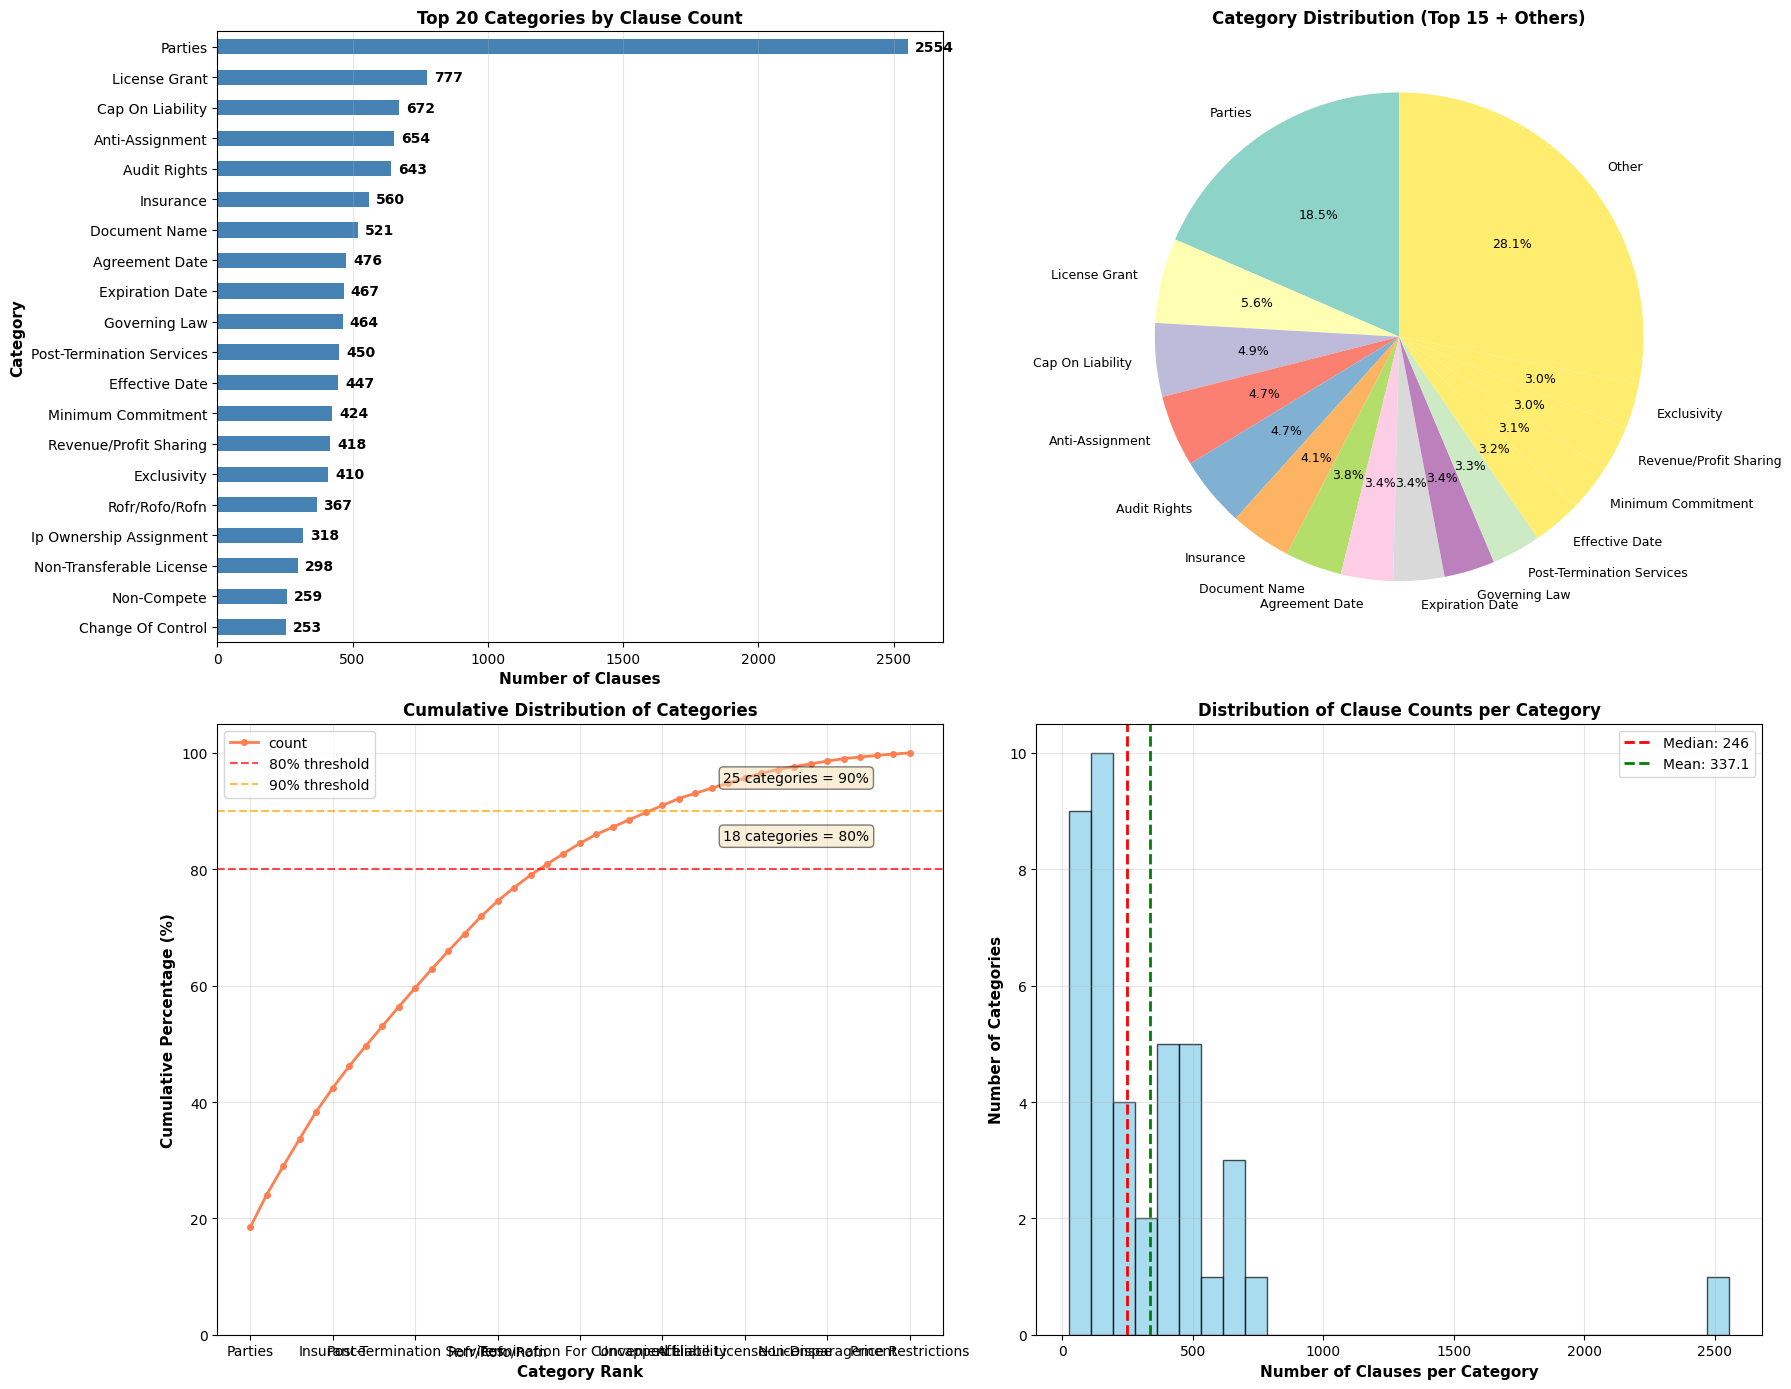


Total categories: 41
Total clauses: 13823

Category Statistics:
  Min clauses per category: 27
  Max clauses per category: 2554
  Mean clauses per category: 337.15
  Median clauses per category: 246
  Std dev: 410.36

Top 10 Categories:
   1. Parties                                  :  2554 clauses (18.48%)
   2. License Grant                            :   777 clauses ( 5.62%)
   3. Cap On Liability                         :   672 clauses ( 4.86%)
   4. Anti-Assignment                          :   654 clauses ( 4.73%)
   5. Audit Rights                             :   643 clauses ( 4.65%)
   6. Insurance                                :   560 clauses ( 4.05%)
   7. Document Name                            :   521 clauses ( 3.77%)
   8. Agreement Date                           :   476 clauses ( 3.44%)
   9. Expiration Date                          :   467 clauses ( 3.38%)
  10. Governing Law                            :   464 clauses ( 3.36%)

Bottom 10 Categories (rarest):
   1. Join

In [28]:
if not clauses_df.empty:
    category_counts = clauses_df['category'].value_counts()
    category_percentages = (clauses_df['category'].value_counts(normalize=True) * 100).round(2)

    
    print("CATEGORY DISTRIBUTION ANALYSIS")
    

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    ax1 = axes[0, 0]
    top_n = min(20, len(category_counts))
    top_categories = category_counts.head(top_n)
    top_categories.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_xlabel('Number of Clauses', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Category', fontsize=11, fontweight='bold')
    ax1.set_title(f'Top {top_n} Categories by Clause Count', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()

    for i, v in enumerate(top_categories.values):
        ax1.text(v + max(top_categories.values) * 0.01, i, str(v), va='center', fontweight='bold')

    ax2 = axes[0, 1]
    top_15_cats = category_counts.head(15)
    other_count = category_counts.iloc[15:].sum() if len(category_counts) > 15 else 0

    if other_count > 0:
        plot_data = pd.concat([top_15_cats, pd.Series({'Other': other_count})])
    else:
        plot_data = top_15_cats

    colors = plt.cm.Set3(range(len(plot_data)))
    plot_data.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90,
                   colors=colors, textprops={'fontsize': 9})
    ax2.set_ylabel('')
    ax2.set_title('Category Distribution (Top 15 + Others)', fontsize=12, fontweight='bold')

    ax3 = axes[1, 0]
    cumsum_pct = (category_counts / category_counts.sum() * 100).cumsum()
    cumsum_pct.plot(kind='line', ax=ax3, marker='o', linewidth=2, markersize=4, color='coral')
    ax3.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
    ax3.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
    ax3.set_xlabel('Category Rank', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
    ax3.set_title('Cumulative Distribution of Categories', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)
    ax3.legend()
    ax3.set_ylim(0, 105)

    cats_80 = (cumsum_pct <= 80).sum()
    cats_90 = (cumsum_pct <= 90).sum()
    ax3.text(len(cumsum_pct) * 0.7, 85, f'{cats_80} categories = 80%',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax3.text(len(cumsum_pct) * 0.7, 95, f'{cats_90} categories = 90%',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax4 = axes[1, 1]
    category_counts.hist(bins=30, ax=ax4, color='skyblue', edgecolor='black', alpha=0.7)
    ax4.axvline(category_counts.median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: {category_counts.median():.0f}')
    ax4.axvline(category_counts.mean(), color='green', linestyle='--', linewidth=2,
                label=f'Mean: {category_counts.mean():.1f}')
    ax4.set_xlabel('Number of Clauses per Category', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Categories', fontsize=11, fontweight='bold')
    ax4.set_title('Distribution of Clause Counts per Category', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('Visualizations/eda_category_distribution.png', bbox_inches='tight', dpi=150)
    plt.show()

    print(f"\nTotal categories: {len(category_counts)}")
    print(f"Total clauses: {category_counts.sum()}")
    print(f"\nCategory Statistics:")
    print(f"  Min clauses per category: {category_counts.min()}")
    print(f"  Max clauses per category: {category_counts.max()}")
    print(f"  Mean clauses per category: {category_counts.mean():.2f}")
    print(f"  Median clauses per category: {category_counts.median():.0f}")
    print(f"  Std dev: {category_counts.std():.2f}")

    print(f"\nTop 10 Categories:")
    for i, (cat, count) in enumerate(category_counts.head(10).items(), 1):
        pct = category_percentages[cat]
        print(f"  {i:2d}. {cat:40s} : {count:5d} clauses ({pct:5.2f}%)")

    print(f"\nBottom 10 Categories (rarest):")
    for i, (cat, count) in enumerate(category_counts.tail(10).items(), 1):
        pct = category_percentages[cat]
        print(f"  {i:2d}. {cat:40s} : {count:5d} clauses ({pct:5.2f}%)")

    
    print("\nCLASS IMBALANCE ANALYSIS")
    
    max_count = category_counts.max()
    min_count = category_counts.min()
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}:1")

    rare_categories = category_counts[category_counts < 10]
    if len(rare_categories) > 0:
        print(f"\n[WARNING]  {len(rare_categories)} categories have < 10 samples:")
        for cat, count in rare_categories.items():
            print(f"     {cat}: {count} clauses")

### 4.2 Text Length Analysis (Critical for Model Architecture)


TEXT LENGTH ANALYSIS


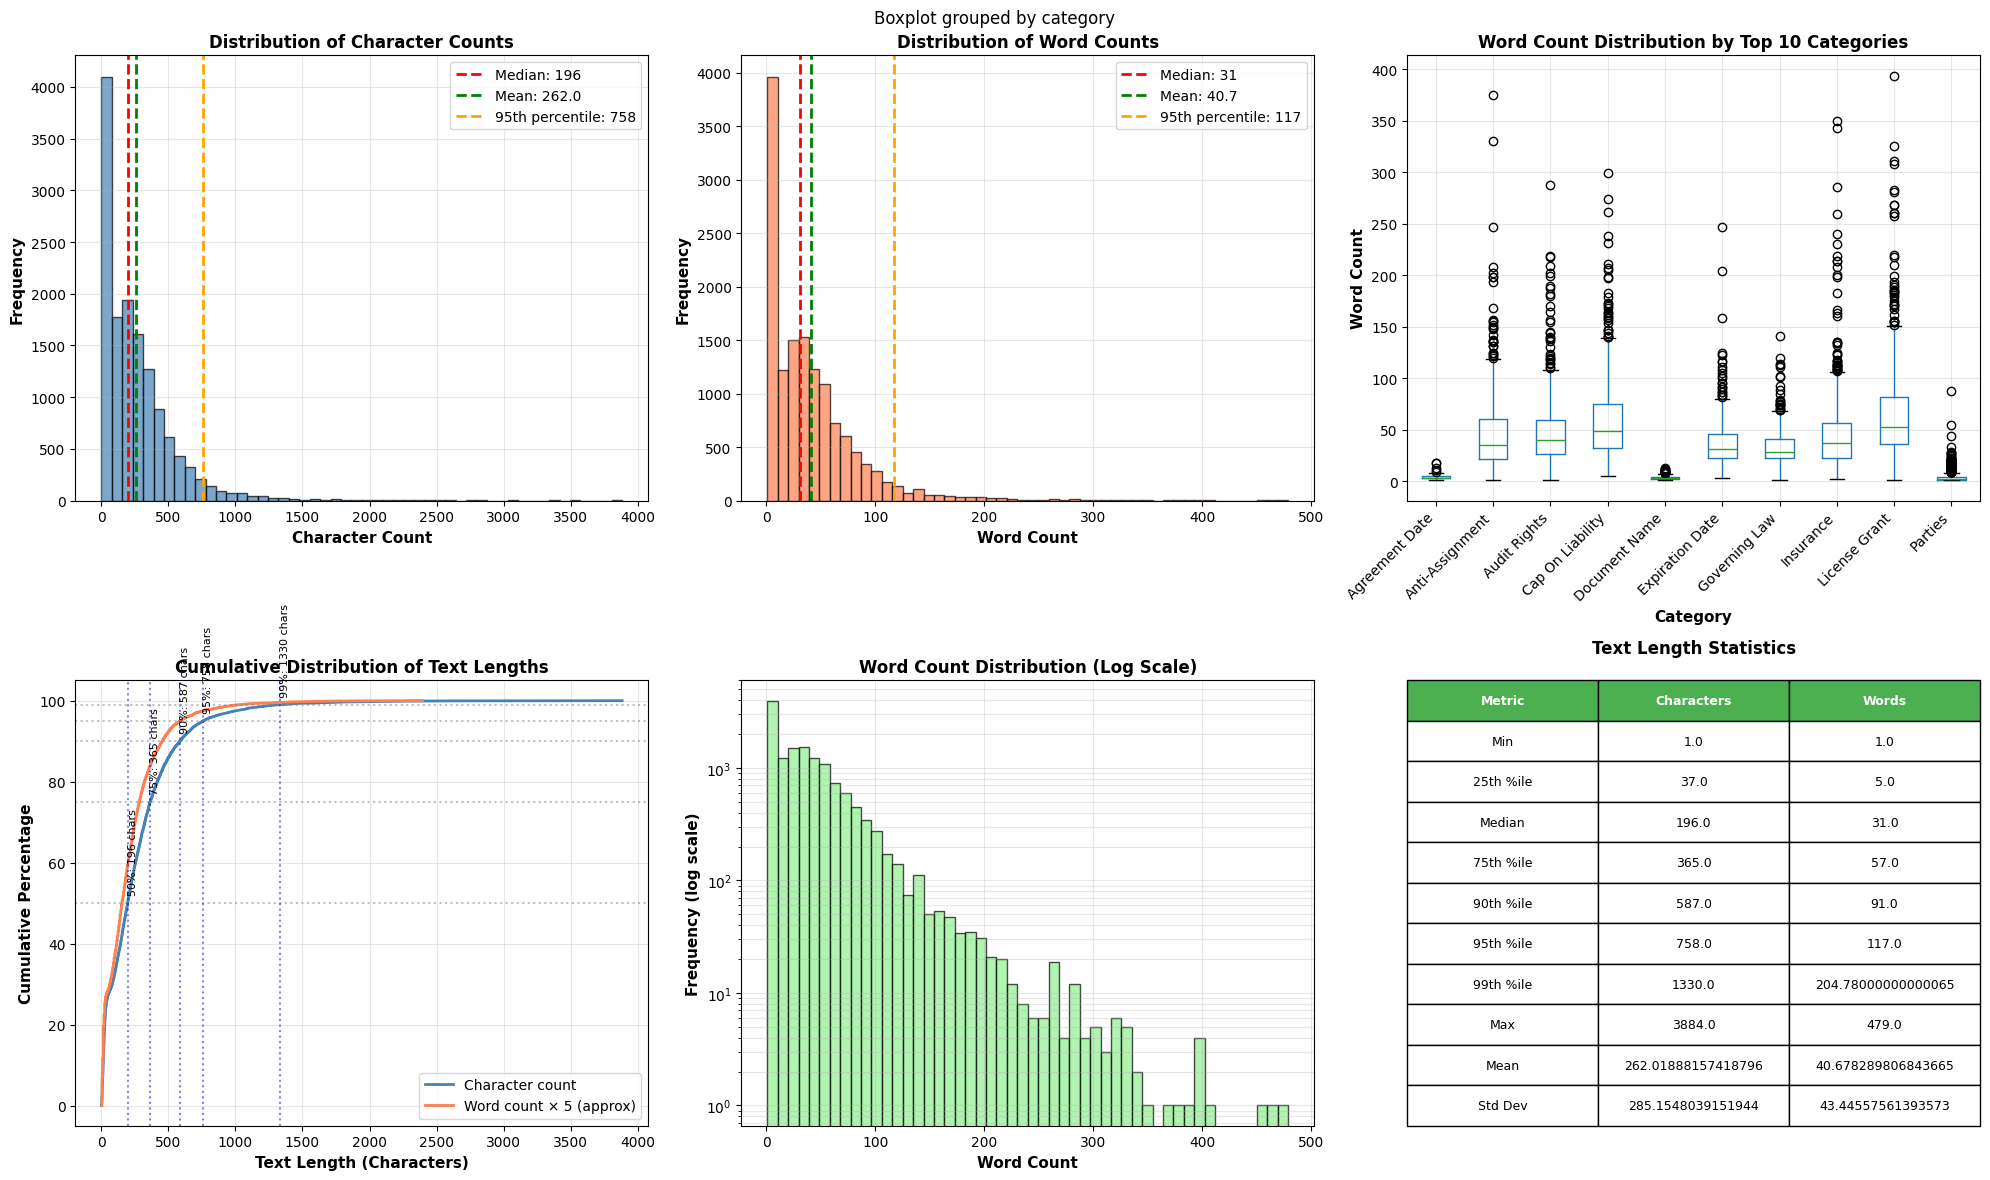


RECOMMENDATIONS FOR MODEL CONFIGURATION

Suggested Max Sequence Lengths:
  Conservative (95th percentile): 117 words / 758 characters
  Comprehensive (99th percentile): 204 words / 1330 characters

  Note: LSTM/Transformer models typically use word/token limits.
        Consider 117-204 tokens for max_sequence_length
  100 tokens: covers 92.4% of clauses
  200 tokens: covers 98.9% of clauses
  300 tokens: covers 99.8% of clauses
  400 tokens: covers 100.0% of clauses
  500 tokens: covers 100.0% of clauses


In [29]:
if not clauses_df.empty:
    clauses_df['char_count'] = clauses_df['clause_text'].str.len()
    clauses_df['word_count'] = clauses_df['clause_text'].str.split().str.len()

    
    print("TEXT LENGTH ANALYSIS")
    

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    ax1 = axes[0, 0]
    clauses_df['char_count'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(clauses_df['char_count'].median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: {clauses_df["char_count"].median():.0f}')
    ax1.axvline(clauses_df['char_count'].mean(), color='green', linestyle='--', linewidth=2,
                label=f'Mean: {clauses_df["char_count"].mean():.1f}')
    ax1.axvline(clauses_df['char_count'].quantile(0.95), color='orange', linestyle='--', linewidth=2,
                label=f'95th percentile: {clauses_df["char_count"].quantile(0.95):.0f}')
    ax1.set_xlabel('Character Count', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Distribution of Character Counts', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2 = axes[0, 1]
    clauses_df['word_count'].hist(bins=50, ax=ax2, color='coral', edgecolor='black', alpha=0.7)
    ax2.axvline(clauses_df['word_count'].median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: {clauses_df["word_count"].median():.0f}')
    ax2.axvline(clauses_df['word_count'].mean(), color='green', linestyle='--', linewidth=2,
                label=f'Mean: {clauses_df["word_count"].mean():.1f}')
    ax2.axvline(clauses_df['word_count'].quantile(0.95), color='orange', linestyle='--', linewidth=2,
                label=f'95th percentile: {clauses_df["word_count"].quantile(0.95):.0f}')
    ax2.set_xlabel('Word Count', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('Distribution of Word Counts', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    ax3 = axes[0, 2]
    top_10_cats = category_counts.head(10).index
    df_top10 = clauses_df[clauses_df['category'].isin(top_10_cats)]
    if not df_top10.empty:
        df_top10.boxplot(column='word_count', by='category', ax=ax3, rot=45)
        ax3.set_xlabel('Category', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Word Count', fontsize=11, fontweight='bold')
        ax3.set_title('Word Count Distribution by Top 10 Categories', fontsize=12, fontweight='bold')
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax3.grid(alpha=0.3)

    ax4 = axes[1, 0]
    sorted_char_counts = np.sort(clauses_df['char_count'])
    percentiles = np.arange(1, len(sorted_char_counts) + 1) / len(sorted_char_counts) * 100
    ax4.plot(sorted_char_counts, percentiles, linewidth=2, color='steelblue', label='Character count')

    sorted_word_counts = np.sort(clauses_df['word_count'])
    percentiles = np.arange(1, len(sorted_word_counts) + 1) / len(sorted_word_counts) * 100
    ax4.plot(sorted_word_counts * 5, percentiles, linewidth=2, color='coral', label='Word count × 5 (approx)')

    for pct in [50, 75, 90, 95, 99]:
        char_val = np.percentile(clauses_df['char_count'], pct)
        word_val = np.percentile(clauses_df['word_count'], pct)
        ax4.axvline(char_val, color='blue', linestyle=':', alpha=0.5)
        ax4.axhline(pct, color='gray', linestyle=':', alpha=0.5)
        ax4.text(char_val, pct + 2, f'{pct}%: {char_val:.0f} chars',
                fontsize=8, rotation=90, va='bottom')

    ax4.set_xlabel('Text Length (Characters)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Cumulative Percentage', fontsize=11, fontweight='bold')
    ax4.set_title('Cumulative Distribution of Text Lengths', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

    ax5 = axes[1, 1]
    word_counts_pos = clauses_df[clauses_df['word_count'] > 0]['word_count']
    ax5.hist(word_counts_pos, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
    ax5.set_yscale('log')
    ax5.set_xlabel('Word Count', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Frequency (log scale)', fontsize=11, fontweight='bold')
    ax5.set_title('Word Count Distribution (Log Scale)', fontsize=12, fontweight='bold')
    ax5.grid(alpha=0.3, which='both')

    ax6 = axes[1, 2]
    ax6.axis('off')

    stats_data = {
        'Metric': ['Min', '25th %ile', 'Median', '75th %ile', '90th %ile', '95th %ile', '99th %ile', 'Max', 'Mean', 'Std Dev'],
        'Characters': [
            clauses_df['char_count'].min(),
            clauses_df['char_count'].quantile(0.25),
            clauses_df['char_count'].median(),
            clauses_df['char_count'].quantile(0.75),
            clauses_df['char_count'].quantile(0.90),
            clauses_df['char_count'].quantile(0.95),
            clauses_df['char_count'].quantile(0.99),
            clauses_df['char_count'].max(),
            clauses_df['char_count'].mean(),
            clauses_df['char_count'].std()
        ],
        'Words': [
            clauses_df['word_count'].min(),
            clauses_df['word_count'].quantile(0.25),
            clauses_df['word_count'].median(),
            clauses_df['word_count'].quantile(0.75),
            clauses_df['word_count'].quantile(0.90),
            clauses_df['word_count'].quantile(0.95),
            clauses_df['word_count'].quantile(0.99),
            clauses_df['word_count'].max(),
            clauses_df['word_count'].mean(),
            clauses_df['word_count'].std()
        ]
    }
    stats_df = pd.DataFrame(stats_data)

    table = ax6.table(cellText=stats_df.values, colLabels=stats_df.columns,
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax6.set_title('Text Length Statistics', fontsize=12, fontweight='bold', pad=20)

    for i in range(len(stats_df.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    plt.tight_layout()
    plt.savefig('Visualizations/eda_text_length_stats.png', bbox_inches='tight', dpi=150)
    plt.show()

    
    print("\nRECOMMENDATIONS FOR MODEL CONFIGURATION")
    

    p95_chars = clauses_df['char_count'].quantile(0.95)
    p99_chars = clauses_df['char_count'].quantile(0.99)
    p95_words = clauses_df['word_count'].quantile(0.95)
    p99_words = clauses_df['word_count'].quantile(0.99)

    print(f"\nSuggested Max Sequence Lengths:")
    print(f"  Conservative (95th percentile): {int(p95_words)} words / {int(p95_chars)} characters")
    print(f"  Comprehensive (99th percentile): {int(p99_words)} words / {int(p99_chars)} characters")
    print(f"\n  Note: LSTM/Transformer models typically use word/token limits.")
    print(f"        Consider {int(p95_words)}-{int(p99_words)} tokens for max_sequence_length")

    for threshold in [100, 200, 300, 400, 500]:
        pct_covered = (clauses_df['word_count'] <= threshold).sum() / len(clauses_df) * 100
        print(f"  {threshold} tokens: covers {pct_covered:.1f}% of clauses")

### 4.3 Clauses per Contract & Category-Specific Analysis


CLAUSES PER CONTRACT & CATEGORY ANALYSIS


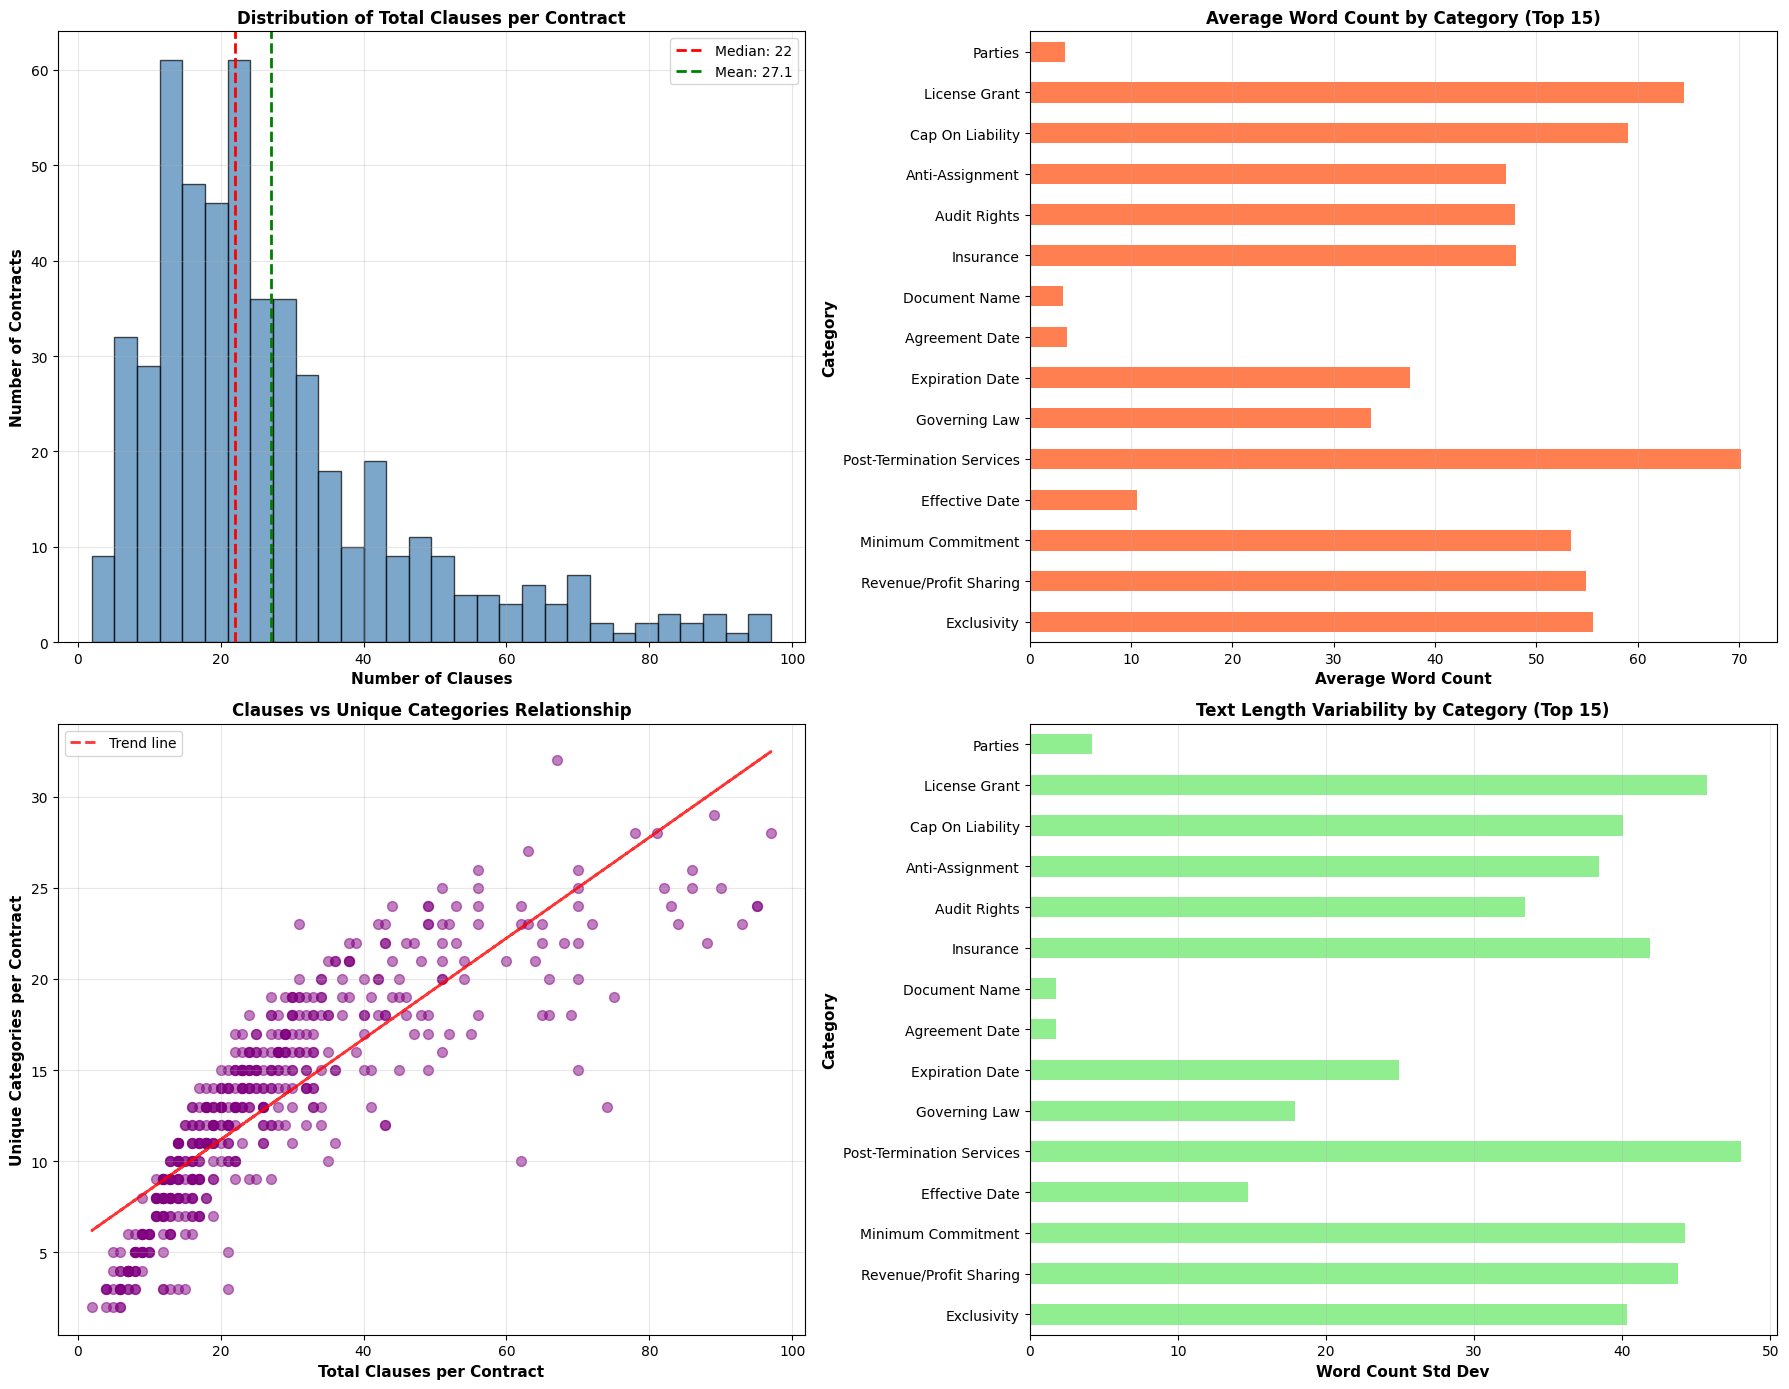


Contract Statistics:
  Total contracts: 510
  Average clauses per contract: 27.10
  Median clauses per contract: 22
  Average unique categories per contract: 13.14

Category Text Characteristics (Top 5 longest & shortest):

Longest average text:
  1. Affiliate License-Licensor                         - 95.3 ± 67.5 words (69 samples)
  2. Affiliate License-Licensee                         - 85.1 ± 55.5 words (115 samples)
  3. Irrevocable Or Perpetual License                   - 83.0 ± 57.9 words (165 samples)
  4. Most Favored Nation                                - 72.4 ± 40.2 words (38 samples)
  5. Uncapped Liability                                 - 70.8 ± 39.3 words (167 samples)

Shortest average text:
  1. Document Name                                      - 3.3 ± 1.8 words (521 samples)
  2. Parties                                            - 3.4 ± 4.2 words (2554 samples)
  3. Agreement Date                                     - 3.7 ± 1.8 words (476 samples)
  4. Effective D

In [30]:
if not clauses_df.empty:
    
    print("CLAUSES PER CONTRACT & CATEGORY ANALYSIS")
    

    clauses_per_contract = clauses_df.groupby('contract_id').agg({
        'clause_text': 'count',
        'category': 'nunique'
    }).rename(columns={'clause_text': 'total_clauses', 'category': 'unique_categories'})

    category_stats = clauses_df.groupby('category').agg({
        'word_count': ['mean', 'median', 'std', 'min', 'max'],
        'char_count': ['mean', 'median'],
        'clause_text': 'count'
    }).round(2)

    category_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) and col[1] else str(col[0]) if isinstance(col, tuple) else str(col)
                              for col in category_stats.columns.values]

    count_col = [col for col in category_stats.columns if 'clause_text' in col or col == 'count']
    if count_col:
        count_col_name = count_col[0]
        category_stats = category_stats.rename(columns={count_col_name: 'clause_text_count'})
        category_stats = category_stats.sort_values('clause_text_count', ascending=False)
    else:
        category_stats = category_stats.sort_values(category_stats.columns[0], ascending=False)
    top_15_cats = category_stats.head(15).index

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    ax1 = axes[0, 0]
    clauses_per_contract['total_clauses'].hist(bins=30, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(clauses_per_contract['total_clauses'].median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: {clauses_per_contract["total_clauses"].median():.0f}')
    ax1.axvline(clauses_per_contract['total_clauses'].mean(), color='green', linestyle='--', linewidth=2,
                label=f'Mean: {clauses_per_contract["total_clauses"].mean():.1f}')
    ax1.set_xlabel('Number of Clauses', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Number of Contracts', fontsize=11, fontweight='bold')
    ax1.set_title('Distribution of Total Clauses per Contract', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2 = axes[0, 1]
    category_stats.loc[top_15_cats, 'word_count_mean'].plot(kind='barh', ax=ax2, color='coral')
    ax2.set_xlabel('Average Word Count', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Category', fontsize=11, fontweight='bold')
    ax2.set_title('Average Word Count by Category (Top 15)', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)

    ax3 = axes[1, 0]
    ax3.scatter(clauses_per_contract['total_clauses'], clauses_per_contract['unique_categories'],
               alpha=0.5, s=50, color='purple')
    ax3.set_xlabel('Total Clauses per Contract', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Unique Categories per Contract', fontsize=11, fontweight='bold')
    ax3.set_title('Clauses vs Unique Categories Relationship', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)

    z = np.polyfit(clauses_per_contract['total_clauses'], clauses_per_contract['unique_categories'], 1)
    p = np.poly1d(z)
    ax3.plot(clauses_per_contract['total_clauses'], p(clauses_per_contract['total_clauses']),
            "r--", alpha=0.8, linewidth=2, label=f'Trend line')
    ax3.legend()

    ax4 = axes[1, 1]
    category_stats.loc[top_15_cats, 'word_count_std'].plot(kind='barh', ax=ax4, color='lightgreen')
    ax4.set_xlabel('Word Count Std Dev', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Category', fontsize=11, fontweight='bold')
    ax4.set_title('Text Length Variability by Category (Top 15)', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('Visualizations/eda_clauses_per_contract.png', bbox_inches='tight', dpi=150)
    plt.show()

    print(f"\nContract Statistics:")
    print(f"  Total contracts: {len(clauses_per_contract)}")
    print(f"  Average clauses per contract: {clauses_per_contract['total_clauses'].mean():.2f}")
    print(f"  Median clauses per contract: {clauses_per_contract['total_clauses'].median():.0f}")
    print(f"  Average unique categories per contract: {clauses_per_contract['unique_categories'].mean():.2f}")

    print(f"\nCategory Text Characteristics (Top 5 longest & shortest):")
    print("\nLongest average text:")
    longest = category_stats.nlargest(5, 'word_count_mean')[['word_count_mean', 'word_count_std', 'clause_text_count']]
    for idx, (cat, row) in enumerate(longest.iterrows(), 1):
        print(f"  {idx}. {cat[:50]:50s} - {row['word_count_mean']:.1f} ± {row['word_count_std']:.1f} words ({int(row['clause_text_count'])} samples)")

    print("\nShortest average text:")
    shortest = category_stats.nsmallest(5, 'word_count_mean')[['word_count_mean', 'word_count_std', 'clause_text_count']]
    for idx, (cat, row) in enumerate(shortest.iterrows(), 1):
        print(f"  {idx}. {cat[:50]:50s} - {row['word_count_mean']:.1f} ± {row['word_count_std']:.1f} words ({int(row['clause_text_count'])} samples)")

### 4.4 Sample Clauses & Data Quality Checks


In [31]:
if not clauses_df.empty:
    
    print("SAMPLE CLAUSES & DATA QUALITY CHECKS")
    

    top_10_categories = category_counts.head(10).index

      
    print("\nSAMPLE CLAUSES BY CATEGORY (Top 10)")
    

    for i, category in enumerate(top_10_categories, 1):
        print(f"\n{i}. CATEGORY: {category}")
        

        cat_clauses = clauses_df[clauses_df['category'] == category]
        print(f"   \nTotal clauses: {len(cat_clauses)}")
        print(f"   \nAvg word count: {cat_clauses['word_count'].mean():.1f} words")

        samples = cat_clauses.sample(min(2, len(cat_clauses)))
        for j, (idx, row) in enumerate(samples.iterrows(), 1):
            print(f"\n   Sample {j} ({row['word_count']} words):")
            text_preview = row['clause_text'][:250] + "..." if len(row['clause_text']) > 250 else row['clause_text']
            print(f"   {text_preview}")

      
    print("\nDATA QUALITY CHECKS")
    

    empty_clauses = clauses_df[clauses_df['clause_text'].str.strip() == '']
    very_short = clauses_df[clauses_df['word_count'] < 3]

    print(f"\n[OK] Empty clauses: {len(empty_clauses)}")
    print(f"[OK] Very short clauses (< 3 words): {len(very_short)} ({len(very_short)/len(clauses_df)*100:.2f}%)")

    duplicate_clauses = clauses_df.duplicated(subset=['clause_text'], keep=False)
    print(f"[OK] Duplicate clause texts: {duplicate_clauses.sum()} ({duplicate_clauses.sum()/len(clauses_df)*100:.2f}%)")

    p99_words = clauses_df['word_count'].quantile(0.99)
    very_long = clauses_df[clauses_df['word_count'] > p99_words]
    print(f"[OK] Very long clauses (> 99th percentile, > {p99_words:.0f} words): {len(very_long)}")

    
    print("\nEDA SUMMARY & RECOMMENDATIONS")
    
    print(f"""
[OK] Dataset Overview:
   - Total clauses: {len(clauses_df):,}
   - Unique categories: {clauses_df['category'].nunique()}
   - Unique contracts: {clauses_df['contract_id'].nunique()}
   - Average clause length: {clauses_df['word_count'].mean():.1f} words
   - Median clause length: {clauses_df['word_count'].median():.0f} words

 Key Findings for Model Design:
   1. Class Imbalance: Imbalance ratio of {category_counts.max()/category_counts.min():.1f}:1
      -> Consider class weights or stratified sampling

   2. Text Length: 95th percentile = {int(clauses_df['word_count'].quantile(0.95))} words
      -> Recommended max_sequence_length: {int(clauses_df['word_count'].quantile(0.95))}-{int(clauses_df['word_count'].quantile(0.99))} tokens

   3. Rare Categories: {len(category_counts[category_counts < 10])} categories have < 10 samples
      -> Consider combining rare categories or using data augmentation

   4. Text Variability: High std dev in word counts across categories
      -> Padding/truncation strategy needed for LSTM model

 Next Steps:
   - Preprocessing: Text cleaning, lowercasing, tokenization
   - Train/Test Split: Stratified split to maintain category distribution
   - Model 1 (Feedforward): TF-IDF features with max_features based on vocab size
   - Model 2 (LSTM): Sequence padding to {int(clauses_df['word_count'].quantile(0.95))} tokens
   - Evaluation: Focus on macro F1-score due to class imbalance
""")

SAMPLE CLAUSES & DATA QUALITY CHECKS

SAMPLE CLAUSES BY CATEGORY (Top 10)

1. CATEGORY: Parties
   
Total clauses: 2554
   
Avg word count: 3.4 words

   Sample 1 (3 words):
   Revolution Medicines, Inc.

   Sample 2 (2 words):
   Sanofi Pasteur

2. CATEGORY: License Grant
   
Total clauses: 777
   
Avg word count: 64.5 words

   Sample 1 (50 words):
   or expiration of this Agreement) a non-exclusive, fully-paid, irrevocable license (including the right to grant sublicenses) under all Intellectual Property Rights and Know-How Controlled by Licensee and embodied within, or claiming or covering the L...

   Sample 2 (84 words):
   If, following the Test, we determine that we will approve the tested item, then for so long as we deem that item to be an "approved item" under this Agreement, you will have the right to use that item under the terms of this Agreement; and we will ha...

3. CATEGORY: Cap On Liability
   
Total clauses: 672
   
Avg word count: 59.0 words

   Sample 1 (13 words)

## 5. Data Preprocessing and Preparation

Prepare data for **multi-class classification** (softmax output) for both models:

**Model 1: Feedforward Neural Network (MLP) with TF-IDF**
- Convert clauses to TF-IDF vectors
- 1-2 hidden layers with ReLU
- Softmax output for multi-class classification
- Sparse Categorical Crossentropy loss, Adam optimizer

**Model 2: LSTM-Based Text Classifier**
- Tokenize into sequences of word IDs
- Random embeddings (can use pretrained later)
- LSTM/BiLSTM to capture word order
- Softmax output for multi-class classification
- Sparse Categorical Crossentropy loss, Adam optimizer


### 5.1 Initial Data Cleaning


In [32]:
print("DATA CLEANING AND PREPARATION")

df_clean = clauses_df.copy()

print(f"\nInitial dataset size: {len(df_clean)} clauses")

initial_size = len(df_clean)
df_clean = df_clean[df_clean['clause_text'].str.strip() != '']
df_clean = df_clean[df_clean['word_count'] >= 2]
print(f"After removing empty/very short clauses: {len(df_clean)} clauses (removed {initial_size - len(df_clean)})")

df_clean = df_clean.drop_duplicates(subset=['clause_text'], keep='first')
print(f"After removing duplicate clause texts: {len(df_clean)} clauses")

min_samples_per_category = 5
category_counts_clean = df_clean['category'].value_counts()
rare_categories = category_counts_clean[category_counts_clean < min_samples_per_category].index

if len(rare_categories) > 0:
    print(f"\n[WARNING]  Found {len(rare_categories)} categories with < {min_samples_per_category} samples:")
    for cat in rare_categories:
        print(f"   - {cat}: {category_counts_clean[cat]} samples")
    print(f"   -> Keeping rare categories (will use class weights in models)")
else:
    print(f"\n[OK] All categories have >= {min_samples_per_category} samples")

print(f"\nFinal cleaned dataset size: {len(df_clean)} clauses")
print(f"Unique categories: {df_clean['category'].nunique()}")


print("\nCATEGORY DISTRIBUTION (After Cleaning):")
print(df_clean['category'].value_counts().head(15))

DATA CLEANING AND PREPARATION

Initial dataset size: 13823 clauses
After removing empty/very short clauses: 12883 clauses (removed 940)
After removing duplicate clause texts: 11047 clauses

[OK] All categories have >= 5 samples

Final cleaned dataset size: 11047 clauses
Unique categories: 41

CATEGORY DISTRIBUTION (After Cleaning):
category
Parties                      1577
License Grant                 658
Audit Rights                  633
Anti-Assignment               614
Insurance                     550
Cap On Liability              545
Governing Law                 453
Agreement Date                434
Expiration Date               415
Revenue/Profit Sharing        414
Post-Termination Services     410
Exclusivity                   402
Minimum Commitment            398
Rofr/Rofo/Rofn                353
Ip Ownership Assignment       310
Name: count, dtype: int64


### 5.2 Text Preprocessing Functions


In [33]:
def clean_text(text, remove_numbers=False, remove_punctuation=False):
    """Clean text for preprocessing."""
    if pd.isna(text) or text == '':
        return ''

    text = str(text).strip()
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)

    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    if remove_punctuation:
        text = re.sub(r'[^\w\s]', '', text)

    return text.strip()

def preprocess_text_for_tfidf(text):
    """Preprocess text for TF-IDF vectorization (Feedforward model)."""
    return clean_text(text, remove_numbers=False, remove_punctuation=False)

def preprocess_text_for_lstm(text):
    """Preprocess text for LSTM model."""
    return clean_text(text, remove_numbers=False, remove_punctuation=False)


print("APPLYING TEXT PREPROCESSING")


df_clean['text_processed'] = df_clean['clause_text'].apply(preprocess_text_for_tfidf)

print(f"\n[OK] Preprocessing applied to {len(df_clean)} clauses")
print(f"\nSample original vs processed:")
for i in range(min(3, len(df_clean))):
    orig = df_clean.iloc[i]['clause_text'][:100]
    proc = df_clean.iloc[i]['text_processed'][:100]
    print(f"\n  Original:  {orig}...")
    print(f"  Processed: {proc}...")

APPLYING TEXT PREPROCESSING

[OK] Preprocessing applied to 11047 clauses

Sample original vs processed:

  Original:  DISTRIBUTOR AGREEMENT...
  Processed: distributor agreement...

  Original:  Electric City Corp....
  Processed: electric city corp....

  Original:  Electric City of Illinois L.L.C....
  Processed: electric city of illinois l.l.c....


### 5.3 Label Encoding and Category Selection


In [34]:
print("LABEL ENCODING AND CATEGORY PREPARATION")
print("\nStrategy: Select 8-10 common categories, group remaining as 'Other'")

top_n_categories = 9
category_counts_sorted = df_clean['category'].value_counts()
top_categories = category_counts_sorted.head(top_n_categories)

print(f"\nSelected top {top_n_categories} common categories:")
for i, (cat, count) in enumerate(top_categories.items(), 1):
    pct = (count / len(df_clean)) * 100
    print(f"  {i:2d}. {cat:40s} : {count:5d} clauses ({pct:5.2f}%)")

remaining_categories = category_counts_sorted.iloc[top_n_categories:]
remaining_count = remaining_categories.sum()
remaining_pct = (remaining_count / len(df_clean)) * 100

print(f"\n  Remaining categories: {len(remaining_categories)} categories")
print(f"  Total clauses in remaining: {remaining_count} ({remaining_pct:.2f}%)")
print(f"  -> Will be grouped as 'Other' category")

df_final = df_clean.copy()

df_final['category_grouped'] = df_final['category'].apply(
    lambda x: x if x in top_categories.index else 'Other'
)

print(f"\n[OK] Category grouping completed:")
print(f"  Total categories after grouping: {df_final['category_grouped'].nunique()}")
print(f"  Category distribution:")
category_grouped_counts = df_final['category_grouped'].value_counts()
for cat, count in category_grouped_counts.items():
    pct = (count / len(df_final)) * 100
    print(f"    {cat:40s} : {count:5d} clauses ({pct:5.2f}%)")

label_encoder = LabelEncoder()
df_final['label_encoded'] = label_encoder.fit_transform(df_final['category_grouped'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

print(f"\n[OK] Label encoding completed:")
print(f"  {len(label_mapping)} categories encoded to integers 0-{len(label_mapping)-1}")
print(f"\n  Label mapping:")
for label, cat in sorted(reverse_label_mapping.items()):
    count = (df_final['category_grouped'] == cat).sum()
    print(f"    {label:2d} -> {cat:40s} ({count:5d} samples)")

num_classes = len(label_mapping)
print(f"\n[OK] Number of classes for models: {num_classes} (including 'Other')")

LABEL ENCODING AND CATEGORY PREPARATION

Strategy: Select 8-10 common categories, group remaining as 'Other'

Selected top 9 common categories:
   1. Parties                                  :  1577 clauses (14.28%)
   2. License Grant                            :   658 clauses ( 5.96%)
   3. Audit Rights                             :   633 clauses ( 5.73%)
   4. Anti-Assignment                          :   614 clauses ( 5.56%)
   5. Insurance                                :   550 clauses ( 4.98%)
   6. Cap On Liability                         :   545 clauses ( 4.93%)
   7. Governing Law                            :   453 clauses ( 4.10%)
   8. Agreement Date                           :   434 clauses ( 3.93%)
   9. Expiration Date                          :   415 clauses ( 3.76%)

  Remaining categories: 32 categories
  Total clauses in remaining: 5168 (46.78%)
  -> Will be grouped as 'Other' category

[OK] Category grouping completed:
  Total categories after grouping: 10
  Category 

### 5.4 Train/Test Split


In [35]:
print("TRAIN/TEST DATA PREPARATION")
print("\nStrategy:")
print("  - Training data: CUADv1.json (all data, validation split will be used during training)")
print("  - Test data: test.json (separate holdout set for final unbiased evaluation)")

print(f"\nTraining data from CUADv1.json:")
print(f"  Total clauses: {len(df_final)}")

X_train = df_final['text_processed'].values
y_train = df_final['label_encoded'].values

print(f"  X_train: {len(X_train)} clauses")
print(f"  y_train: {len(y_train)} labels")

print(f"\nExtracting test data from test.json...")
test_file = data_path / "test.json"

if test_file.exists():
    test_clauses_df = extract_clauses_from_cuadv1(test_file)

    if not test_clauses_df.empty:
        print(f"  Raw test clauses extracted: {len(test_clauses_df)}")

        test_clauses_df = test_clauses_df[test_clauses_df['clause_text'].str.strip() != '']
        test_clauses_df = test_clauses_df[test_clauses_df['word_count'] >= 2]
        test_clauses_df = test_clauses_df.drop_duplicates(subset=['clause_text'], keep='first')

        test_clauses_df['text_processed'] = test_clauses_df['clause_text'].apply(preprocess_text_for_tfidf)

        test_clauses_df['category_grouped'] = test_clauses_df['category'].apply(
            lambda x: x if x in top_categories.index else 'Other'
        )

        test_clauses_df = test_clauses_df[test_clauses_df['category_grouped'].isin(label_encoder.classes_)]

        test_clauses_df['label_encoded'] = label_encoder.transform(test_clauses_df['category_grouped'])

        X_test = test_clauses_df['text_processed'].values
        y_test = test_clauses_df['label_encoded'].values

        print(f"  X_test: {len(X_test)} clauses (after filtering and grouping)")
        print(f"  y_test: {len(y_test)} labels")

        print(f"\nTest set category distribution:")
        test_dist = pd.Series(y_test).value_counts().sort_index()
        for label, count in test_dist.items():
            cat_name = reverse_label_mapping[label]
            pct = (count / len(y_test)) * 100 if len(y_test) > 0 else 0
            print(f"  {label:2d} ({cat_name[:35]:35s}): {count:4d} samples ({pct:5.2f}%)")

        print(f"\n[OK] Using test.json as final test set")

    else:
        print("  WARNING: No clauses extracted from test.json")
        print("  Falling back to train/test split from CUADv1.json")
        X_train, X_test, y_train, y_test = train_test_split(
            X_train, y_train,
            test_size=0.2,
            random_state=42,
            stratify=y_train,
            shuffle=True
        )
        print(f"  Split: {len(X_train)} train, {len(X_test)} test")
else:
    print(f"  WARNING: test.json not found at {test_file}")
    print("  Falling back to train/test split from CUADv1.json")
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train,
        shuffle=True
    )
    print(f"  Split: {len(X_train)} train, {len(X_test)} test")

print(f"\nFinal data split:")
print(f"  Training set: {len(X_train)} clauses")
print(f"  Test set: {len(X_test)} clauses")
print(f"  Training percentage: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}%" if (len(X_train)+len(X_test)) > 0 else "")
print(f"  Test percentage: {len(X_test)/(len(X_train)+len(X_test))*100:.1f}%" if (len(X_train)+len(X_test)) > 0 else "")

from sklearn.utils.class_weight import compute_class_weight

class_weights_dict = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_dict))

print(f"\nClass weights calculated (for imbalanced handling):")
for label, weight in list(class_weights.items())[:5]:
    cat_name = reverse_label_mapping[label]
    print(f"  {label:2d} ({cat_name[:35]:35s}): {weight:.3f}")
print(f"  ... (showing first 5, {len(class_weights)} total)")

print(f"\nLabels prepared for multi-class classification:")
print(f"  y_train: {y_train.shape} (integer labels, 0 to {num_classes-1})")
print(f"  y_test: {y_test.shape} (integer labels)")
print(f"  Loss function: Sparse Categorical Crossentropy")
print(f"  Output activation: Softmax")

TRAIN/TEST DATA PREPARATION

Strategy:
  - Training data: CUADv1.json (all data, validation split will be used during training)
  - Test data: test.json (separate holdout set for final unbiased evaluation)

Training data from CUADv1.json:
  Total clauses: 11047
  X_train: 11047 clauses
  y_train: 11047 labels

Extracting test data from test.json...
Processing 102 contracts...

[OK] Extracted 2643 clauses from 102 contracts
   Unique categories: 40
   Unique contracts: 102
  Raw test clauses extracted: 2643
  X_test: 2172 clauses (after filtering and grouping)
  y_test: 2172 labels

Test set category distribution:
   0 (Agreement Date                     ):   87 samples ( 4.01%)
   1 (Anti-Assignment                    ):  128 samples ( 5.89%)
   2 (Audit Rights                       ):  102 samples ( 4.70%)
   3 (Cap On Liability                   ):  106 samples ( 4.88%)
   4 (Expiration Date                    ):   73 samples ( 3.36%)
   5 (Governing Law                      ):   90 

### 5.5 Prepare Data for Feedforward Model (TF-IDF)


In [36]:
print("PREPARING TF-IDF FEATURES FOR FEEDFORWARD NEURAL NETWORK (MLP)")
print("\nModel Architecture Plan:")
print("  - Input: TF-IDF vectors (dense arrays)")
print("  - Hidden layers: 1-2 layers with ReLU activation")
print("  - Output: Softmax activation for multi-class classification")
print("  - Loss: Sparse Categorical Crossentropy")
print("  - Optimizer: Adam")

max_features = 5000
min_df = 2
max_df = 0.95

tfidf_vectorizer = TfidfVectorizer(
    max_features=max_features,
    min_df=min_df,
    max_df=max_df,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    strip_accents='unicode'
)

print(f"\nFitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nConverting sparse matrices to dense arrays...")
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

print(f"\n[OK] TF-IDF transformation completed:")
print(f"  Training features shape: {X_train_tfidf_dense.shape}")
print(f"  Test features shape: {X_test_tfidf_dense.shape}")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"  Actual features: {X_train_tfidf_dense.shape[1]}")

sparsity_train = (1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100
print(f"  Sparsity: {sparsity_train:.2f}% (converted to dense)")

print(f"\n[OK] Data ready for Feedforward Neural Network (MLP) with TF-IDF!")
print(f"   Input shape: {X_train_tfidf_dense.shape[1]} features")
print(f"   Output shape: {num_classes} classes (softmax)")

PREPARING TF-IDF FEATURES FOR FEEDFORWARD NEURAL NETWORK (MLP)

Model Architecture Plan:
  - Input: TF-IDF vectors (dense arrays)
  - Hidden layers: 1-2 layers with ReLU activation
  - Output: Softmax activation for multi-class classification
  - Loss: Sparse Categorical Crossentropy
  - Optimizer: Adam

Fitting TF-IDF vectorizer on training data...

Converting sparse matrices to dense arrays...

[OK] TF-IDF transformation completed:
  Training features shape: (11047, 5000)
  Test features shape: (2172, 5000)
  Vocabulary size: 5000
  Actual features: 5000
  Sparsity: 99.56% (converted to dense)

[OK] Data ready for Feedforward Neural Network (MLP) with TF-IDF!
   Input shape: 5000 features
   Output shape: 10 classes (softmax)


use tfidf with traditional models
to get sequential info use static embedding(try)

### 5.6 Prepare Data for LSTM Model (Tokenization & Padding)


In [37]:
print("PREPARING SEQUENCE DATA FOR LSTM-BASED TEXT CLASSIFIER")
print("\nModel Architecture Plan:")
print("  - Input: Tokenized sequences (word IDs)")
print("  - Embedding: Random embeddings (or pretrained)")
print("  - LSTM/BiLSTM: Capture word order and context")
print("  - Output: Softmax activation for multi-class classification")
print("  - Loss: Sparse Categorical Crossentropy")
print("  - Optimizer: Adam")
print("\nWhy LSTM: Captures word order important for legal phrases like")
print("  'subject to', 'shall remain', 'governing law shall be...'")

word_counts = [len(text.split()) for text in X_train]
p95_length = int(np.percentile(word_counts, 95))
p99_length = int(np.percentile(word_counts, 99))
max_sequence_length = min(p95_length + 20, 300)

print(f"\nSequence length analysis:")
print(f"  95th percentile: {p95_length} words")
print(f"  99th percentile: {p99_length} words")
print(f"  Selected max_sequence_length: {max_sequence_length}")

vocab_size = 10000
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
    lower=True,
    split=' '
)

print(f"\nFitting tokenizer on training data...")
tokenizer.fit_on_texts(X_train)

actual_vocab_size = len(tokenizer.word_index) + 1
print(f"  Actual vocabulary size: {actual_vocab_size:,} words")
print(f"  Using top {min(vocab_size, actual_vocab_size):,} words")

print(f"\nConverting texts to sequences...")
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(f"Padding sequences to length {max_sequence_length}...")
X_train_padded = pad_sequences(
    X_train_seq,
    maxlen=max_sequence_length,
    padding='post',
    truncating='post'
)

X_test_padded = pad_sequences(
    X_test_seq,
    maxlen=max_sequence_length,
    padding='post',
    truncating='post'
)

print(f"\n[OK] Sequence preparation completed:")
print(f"  Training sequences shape: {X_train_padded.shape}")
print(f"  Test sequences shape: {X_test_padded.shape}")
print(f"  Max sequence length: {max_sequence_length}")
print(f"  Vocabulary size: {actual_vocab_size:,}")

train_truncated = sum([len(seq) > max_sequence_length for seq in X_train_seq])
test_truncated = sum([len(seq) > max_sequence_length for seq in X_test_seq])

print(f"\nTruncation statistics:")
print(f"  Train sequences truncated: {train_truncated} ({train_truncated/len(X_train_seq)*100:.2f}%)")
print(f"  Test sequences truncated: {test_truncated} ({test_truncated/len(X_test_seq)*100:.2f}%)")

print(f"\n[OK] Data ready for LSTM-Based Text Classifier!")
print(f"   Input shape: ({max_sequence_length},) - sequences of word IDs")
print(f"   Embedding input dim: {actual_vocab_size:,}")
print(f"   Output shape: {num_classes} classes (softmax)")

PREPARING SEQUENCE DATA FOR LSTM-BASED TEXT CLASSIFIER

Model Architecture Plan:
  - Input: Tokenized sequences (word IDs)
  - Embedding: Random embeddings (or pretrained)
  - LSTM/BiLSTM: Capture word order and context
  - Output: Softmax activation for multi-class classification
  - Loss: Sparse Categorical Crossentropy
  - Optimizer: Adam

Why LSTM: Captures word order important for legal phrases like
  'subject to', 'shall remain', 'governing law shall be...'

Sequence length analysis:
  95th percentile: 118 words
  99th percentile: 207 words
  Selected max_sequence_length: 138

Fitting tokenizer on training data...
  Actual vocabulary size: 9,833 words
  Using top 9,833 words

Converting texts to sequences...
Padding sequences to length 138...

[OK] Sequence preparation completed:
  Training sequences shape: (11047, 138)
  Test sequences shape: (2172, 138)
  Max sequence length: 138
  Vocabulary size: 9,833

Truncation statistics:
  Train sequences truncated: 397 (3.59%)
  Test se

### 5.7 Preprocessing Summary


In [38]:
print("PREPROCESSING SUMMARY - READY FOR MODEL CREATION")

print(f"""
[OK] Data Preprocessing Complete for Multi-Class Classification!

 Dataset Overview:
   - Original clauses: {len(clauses_df):,}
   - After cleaning: {len(df_final):,}
   - Selected categories: {num_classes} (top categories)
   - Train samples: {len(X_train):,}
   - Test samples: {len(X_test):,}



 Model 1: Feedforward Neural Network (MLP) with TF-IDF

   - X_train_tfidf_dense: {X_train_tfidf_dense.shape}
   - X_test_tfidf_dense: {X_test_tfidf_dense.shape}
   - Features: {X_train_tfidf_dense.shape[1]:,} TF-IDF features
   - Architecture: Input({X_train_tfidf_dense.shape[1]}) -> Hidden(ReLU) -> Output({num_classes}, Softmax)



 Model 2: LSTM-Based Text Classifier

   - X_train_padded: {X_train_padded.shape}
   - X_test_padded: {X_test_padded.shape}
   - Vocabulary size: {actual_vocab_size:,}
   - Max sequence length: {max_sequence_length}
   - Architecture: Input({max_sequence_length}) -> Embedding({actual_vocab_size:,}) -> LSTM -> Output({num_classes}, Softmax)



 Labels (Both Models):
   - y_train: {y_train.shape} (integer labels: 0 to {num_classes-1})
   - y_test: {y_test.shape} (integer labels)
   - Loss: Sparse Categorical Crossentropy
   - Output: Softmax ({num_classes} classes)
   - Class weights: Computed for imbalanced handling

 Ready to create models!
""")

PREPROCESSING SUMMARY - READY FOR MODEL CREATION

[OK] Data Preprocessing Complete for Multi-Class Classification!

 Dataset Overview:
   - Original clauses: 13,823
   - After cleaning: 11,047
   - Selected categories: 10 (top categories)
   - Train samples: 11,047
   - Test samples: 2,172



 Model 1: Feedforward Neural Network (MLP) with TF-IDF

   - X_train_tfidf_dense: (11047, 5000)
   - X_test_tfidf_dense: (2172, 5000)
   - Features: 5,000 TF-IDF features
   - Architecture: Input(5000) -> Hidden(ReLU) -> Output(10, Softmax)



 Model 2: LSTM-Based Text Classifier

   - X_train_padded: (11047, 138)
   - X_test_padded: (2172, 138)
   - Vocabulary size: 9,833
   - Max sequence length: 138
   - Architecture: Input(138) -> Embedding(9,833) -> LSTM -> Output(10, Softmax)



 Labels (Both Models):
   - y_train: (11047,) (integer labels: 0 to 9)
   - y_test: (2172,) (integer labels)
   - Loss: Sparse Categorical Crossentropy
   - Output: Softmax (10 classes)
   - Class weights: Computed f

## 6. Model Creation and Training

Create and train both models:
1. Feedforward Neural Network (MLP) with TF-IDF features
2. LSTM-Based Text Classifier with sequence embeddings


### 6.1 Model 1: Feedforward Neural Network (MLP) with TF-IDF


In [39]:
print("MODEL 1: FEEDFORWARD NEURAL NETWORK (MLP) WITH TF-IDF")

input_dim = X_train_tfidf_dense.shape[1]
hidden_units_1 = 512
hidden_units_2 = 256
dropout_rate = 0.3

print(f"\nModel Architecture:")
print(f"  Input Layer: {input_dim} features (TF-IDF)")
print(f"  Hidden Layer 1: {hidden_units_1} units, ReLU activation")
print(f"  Dropout: {dropout_rate}")
print(f"  Hidden Layer 2: {hidden_units_2} units, ReLU activation")
print(f"  Dropout: {dropout_rate}")
print(f"  Output Layer: {num_classes} units, Softmax activation")
print(f"  Total Parameters: ~{(input_dim * hidden_units_1 + hidden_units_1 * hidden_units_2 + hidden_units_2 * num_classes):,}")

model_ff = Sequential([
    Dense(hidden_units_1, activation='relu', input_dim=input_dim, name='hidden_1'),
    Dropout(dropout_rate, name='dropout_1'),
    Dense(hidden_units_2, activation='relu', name='hidden_2'),
    Dropout(dropout_rate, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

model_ff.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel compiled successfully!")
print(f"\nModel Summary:")
model_ff.summary()

MODEL 1: FEEDFORWARD NEURAL NETWORK (MLP) WITH TF-IDF

Model Architecture:
  Input Layer: 5000 features (TF-IDF)
  Hidden Layer 1: 512 units, ReLU activation
  Dropout: 0.3
  Hidden Layer 2: 256 units, ReLU activation
  Dropout: 0.3
  Output Layer: 10 units, Softmax activation
  Total Parameters: ~2,693,632

Model compiled successfully!

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,694,410 (10.28 MB)

 Trainable params: 2,694,410 (10.28 MB)

 Non-trainable params: 0 (0.00 B)

try reducing drop out rate and hiddenlayer
experiment...

#### 6.1.1 Train Feedforward Model


In [40]:
print("TRAINING FEEDFORWARD NEURAL NETWORK")

batch_size = 64
epochs = 50
validation_split = 0.1

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'Models/best_model_ff.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print(f"\nTraining Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Max epochs: {epochs}")
print(f"  Validation split: {validation_split}")
print(f"  Early stopping: Patience = 5")
print(f"  Class weights: Using balanced weights")

print(f"\nStarting training...")
history_ff = model_ff.fit(
    X_train_tfidf_dense, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print(f"\nTraining completed!")
print(f"  Best epoch: {len(history_ff.history['loss'])}")
print(f"  Best validation loss: {min(history_ff.history['val_loss']):.4f}")
print(f"  Best validation accuracy: {max(history_ff.history['val_accuracy']):.4f}")

TRAINING FEEDFORWARD NEURAL NETWORK

Training Configuration:
  Batch size: 64
  Max epochs: 50
  Validation split: 0.1
  Early stopping: Patience = 5
  Class weights: Using balanced weights

Starting training...
Epoch 1/50
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5532 - loss: 1.5510
Epoch 1: val_loss improved from None to 0.60829, saving model to Models/best_model_ff.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7025 - loss: 0.9003 - val_accuracy: 0.8217 - val_loss: 0.6083
Epoch 2/50
150/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8660 - loss: 0.2142
Epoch 2: val_loss improved from 0.60829 to 0.51557, saving model to Models/best_model_ff.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8905 - loss: 0.1649 - val_accuracy: 0.8661 - val_loss: 0.5156
Epoch 3/50
151/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9243 - loss: 0.0963
Epoch 3: val_loss did not improve from 0.51557
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9330 - loss: 0.0869 - val_accuracy: 0.8534 - val_loss: 0.5630
Epoch 4/50
153/156 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9424 - loss: 0.0650
Epoch 4: val_loss did not improve from 0.51557
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9468 - loss: 0.0610 - val_accuracy: 0.8652 - val_loss: 0.5673
Epoch 5/50
153/156 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9576 - loss: 0.0476
Epoch 5: val_loss did not improve from 0.51557
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9625 - loss: 0.0447 - val_accuracy: 0.8742 - val_loss: 0.5812
Epoch 6/50
154/156 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9684 - loss: 0.0368
Epoch 6: val_loss did not improve from 0.51557


#### 6.1.2 Evaluate Feedforward Model

We evaluate the Feedforward model's performance by calculating overall metrics and per-class accuracy/precision for each legal clause category. This helps us understand which categories the model predicts most accurately and identify areas for improvement.


EVALUATING FEEDFORWARD NEURAL NETWORK

Test Set Performance:
  Loss: 0.2679
  Accuracy: 0.9217 (92.17%)

Classification Report:
                  precision    recall  f1-score   support

  Agreement Date       0.86      1.00      0.93        87
 Anti-Assignment       0.88      0.98      0.93       128
    Audit Rights       0.96      1.00      0.98       102
Cap On Liability       0.89      0.96      0.92       106
 Expiration Date       0.70      0.97      0.82        73
   Governing Law       0.97      0.99      0.98        90
       Insurance       0.95      0.99      0.97       116
   License Grant       0.61      0.95      0.74       107
           Other       0.99      0.85      0.91       998
         Parties       0.98      0.99      0.98       365

        accuracy                           0.92      2172
       macro avg       0.88      0.97      0.92      2172
    weighted avg       0.94      0.92      0.92      2172


Overall Metrics:
  Precision (weighted): 0.9381
  Recall

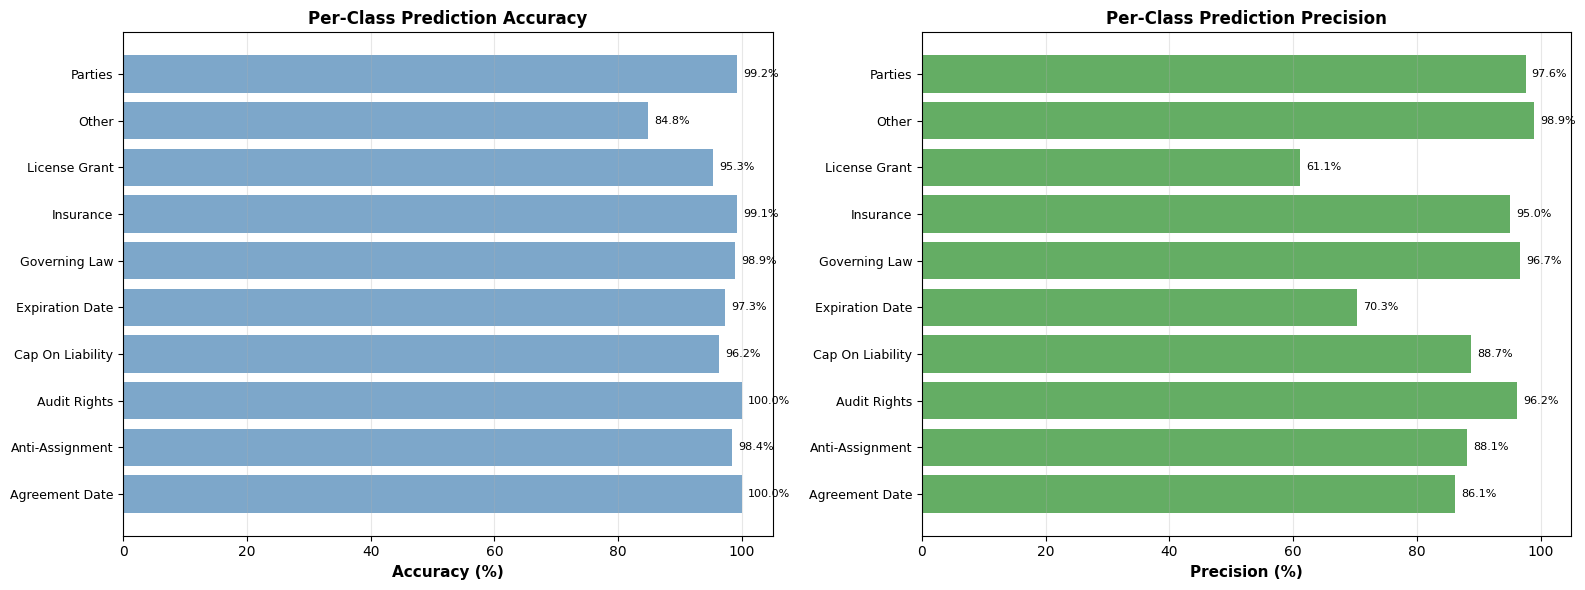


Confusion Matrix:
[[ 87   0   0   0   0   0   0   0   0   0]
 [  0 126   0   0   0   0   0   0   1   1]
 [  0   0 102   0   0   0   0   0   0   0]
 [  0   0   0 102   0   1   1   0   2   0]
 [  1   0   0   0  71   0   0   0   1   0]
 [  0   0   0   0   0  89   0   0   0   1]
 [  0   0   0   0   1   0 115   0   0   0]
 [  0   0   0   0   0   0   0 102   4   1]
 [ 13  16   4  13  29   2   4  65 846   6]
 [  0   1   0   0   0   0   1   0   1 362]]


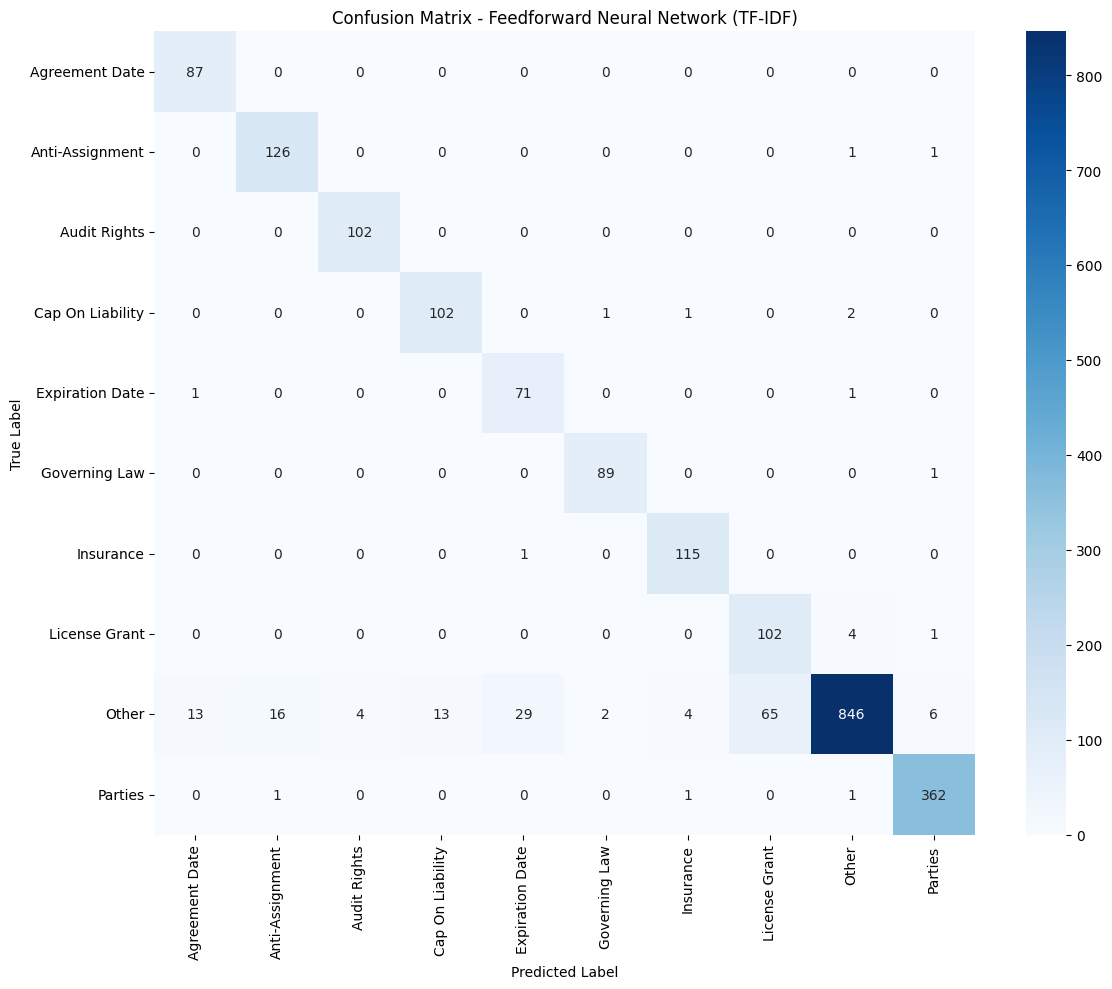

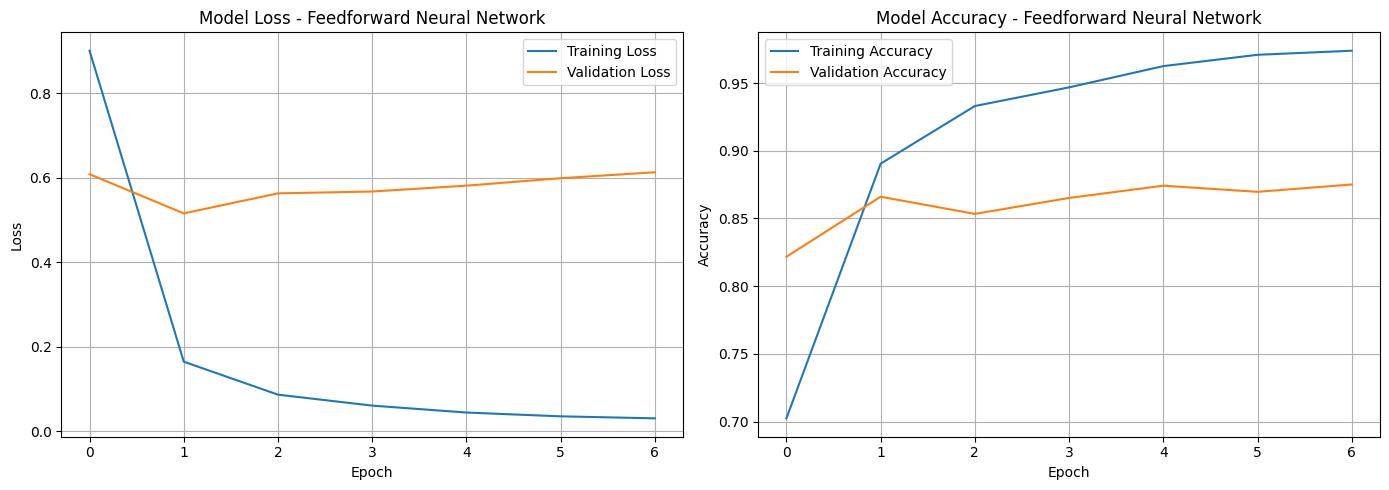

In [41]:
print("EVALUATING FEEDFORWARD NEURAL NETWORK")
y_pred_ff = model_ff.predict(X_test_tfidf_dense, verbose=0)
y_pred_ff_classes = np.argmax(y_pred_ff, axis=1)
test_loss_ff, test_accuracy_ff = model_ff.evaluate(X_test_tfidf_dense, y_test, verbose=0)

print(f"\nTest Set Performance:")
print(f"  Loss: {test_loss_ff:.4f}")
print(f"  Accuracy: {test_accuracy_ff:.4f} ({test_accuracy_ff*100:.2f}%)")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ff_classes,
                          target_names=[reverse_label_mapping[i] for i in range(num_classes)]))

precision_ff = precision_score(y_test, y_pred_ff_classes, average='weighted', zero_division=0)
recall_ff = recall_score(y_test, y_pred_ff_classes, average='weighted', zero_division=0)
f1_ff = f1_score(y_test, y_pred_ff_classes, average='weighted', zero_division=0)
f1_macro_ff = f1_score(y_test, y_pred_ff_classes, average='macro', zero_division=0)

print(f"\nOverall Metrics:")
print(f"  Precision (weighted): {precision_ff:.4f}")
print(f"  Recall (weighted): {recall_ff:.4f}")
print(f"  F1-score (weighted): {f1_ff:.4f}")
print(f"  F1-score (macro): {f1_macro_ff:.4f}")

cm_ff = confusion_matrix(y_test, y_pred_ff_classes)
precision_per_class_ff = precision_score(y_test, y_pred_ff_classes, average=None, zero_division=0)
accuracy_per_class_ff = cm_ff.diagonal() / cm_ff.sum(axis=1)

print(f"\nPer-Class Prediction Accuracy and Precision")
print(f"\n{'Category':<45} {'Test Samples':<15} {'Correct':<12} {'Accuracy %':<15} {'Precision %':<15}")
print("-" * 102)
for i in range(num_classes):
    category_name = reverse_label_mapping[i][:43]
    true_count = int(cm_ff.sum(axis=1)[i])
    correct_count = int(cm_ff.diagonal()[i])
    accuracy_pct = accuracy_per_class_ff[i] * 100
    precision_pct = precision_per_class_ff[i] * 100
    print(f"{category_name:<45} {true_count:<15} {correct_count:<12} {accuracy_pct:<15.2f} {precision_pct:<15.2f}")

category_names = [reverse_label_mapping[i] for i in range(num_classes)]
accuracy_pct_ff = accuracy_per_class_ff * 100
precision_pct_ff = precision_per_class_ff * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x_pos = np.arange(len(category_names))

axes[0].barh(x_pos, accuracy_pct_ff, color='steelblue', alpha=0.7)
axes[0].set_yticks(x_pos)
axes[0].set_yticklabels(category_names, fontsize=9)
axes[0].set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Per-Class Prediction Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlim([0, 105])
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracy_pct_ff):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

axes[1].barh(x_pos, precision_pct_ff, color='forestgreen', alpha=0.7)
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(category_names, fontsize=9)
axes[1].set_xlabel('Precision (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Per-Class Prediction Precision', fontsize=12, fontweight='bold')
axes[1].set_xlim([0, 105])
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(precision_pct_ff):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('Visualizations/feedforward_per_class_accuracy_precision.png', bbox_inches='tight', dpi=150)
plt.show()

results_ff = {
    'model': 'Feedforward MLP (TF-IDF)',
    'test_accuracy': test_accuracy_ff,
    'test_loss': test_loss_ff,
    'precision': precision_ff,
    'recall': recall_ff,
    'f1_weighted': f1_ff,
    'f1_macro': f1_macro_ff
}

print(f"\nConfusion Matrix:")
print(cm_ff)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_ff, annot=True, fmt='d', cmap='Blues',
            xticklabels=[reverse_label_mapping[i][:20] for i in range(num_classes)],
            yticklabels=[reverse_label_mapping[i][:20] for i in range(num_classes)])
plt.title('Confusion Matrix - Feedforward Neural Network (TF-IDF)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('Visualizations/feedforward_confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ff.history['loss'], label='Training Loss')
axes[0].plot(history_ff.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss - Feedforward Neural Network')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_ff.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_ff.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy - Feedforward Neural Network')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('Visualizations/feedforward_training_history.png', bbox_inches='tight', dpi=150)
plt.show()

In [42]:
print("MODEL 2: LSTM-BASED TEXT CLASSIFIER")

embedding_dim = 128
lstm_units = 128
dropout_rate = 0.3
recurrent_dropout = 0.2

print(f"\nModel Architecture:")
print(f"  Input Layer: Sequences of length {max_sequence_length}")
print(f"  Embedding Layer: {actual_vocab_size:,} vocab size, {embedding_dim} dims (random embeddings)")
print(f"  LSTM Layer: {lstm_units} units")
print(f"  Dropout: {dropout_rate}, Recurrent Dropout: {recurrent_dropout}")
print(f"  Dense Layer: {num_classes} units, Softmax activation")

model_lstm = Sequential([
    Embedding(input_dim=actual_vocab_size,
              output_dim=embedding_dim,
              input_length=max_sequence_length,
              name='embedding'),
    LSTM(lstm_units,
         dropout=dropout_rate,
         recurrent_dropout=recurrent_dropout,
         name='lstm'),
    Dropout(dropout_rate, name='dropout'),
    Dense(num_classes, activation='softmax', name='output')
])

model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel compiled successfully!")
print(f"\nModel Summary:")
model_lstm.summary()


use_bilstm = False

if use_bilstm:
    print("\nUsing Bidirectional LSTM for better context understanding...")
    model_lstm = Sequential([
        Embedding(input_dim=actual_vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_sequence_length,
                  name='embedding'),
        Bidirectional(LSTM(lstm_units,
                           dropout=dropout_rate,
                           recurrent_dropout=recurrent_dropout),
                      name='bilstm'),
        Dropout(dropout_rate, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])
    model_lstm.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

MODEL 2: LSTM-BASED TEXT CLASSIFIER

Model Architecture:
  Input Layer: Sequences of length 138
  Embedding Layer: 9,833 vocab size, 128 dims (random embeddings)
  LSTM Layer: 128 units
  Dropout: 0.3, Recurrent Dropout: 0.2
  Dense Layer: 10 units, Softmax activation

Model compiled successfully!

Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 6.2.1 Train LSTM Model


In [43]:
print("TRAINING LSTM-BASED TEXT CLASSIFIER")

batch_size = 32
epochs = 50
validation_split = 0.1

early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_lstm = ModelCheckpoint(
    'Models/best_model_lstm.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print(f"\nTraining Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Max epochs: {epochs}")
print(f"  Validation split: {validation_split}")
print(f"  Early stopping: Patience = 5")
print(f"  Class weights: Using balanced weights")

print(f"\nStarting training...")
history_lstm = model_lstm.fit(
    X_train_padded, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    class_weight=class_weights,
    callbacks=[early_stopping_lstm, model_checkpoint_lstm],
    verbose=1
)

print(f"\nTraining completed!")
print(f"  Best epoch: {len(history_lstm.history['loss'])}")
print(f"  Best validation loss: {min(history_lstm.history['val_loss']):.4f}")
print(f"  Best validation accuracy: {max(history_lstm.history['val_accuracy']):.4f}")

TRAINING LSTM-BASED TEXT CLASSIFIER

Training Configuration:
  Batch size: 32
  Max epochs: 50
  Validation split: 0.1
  Early stopping: Patience = 5
  Class weights: Using balanced weights

Starting training...
Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0808 - loss: 2.2928
Epoch 1: val_loss improved from None to 2.31241, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.1062 - loss: 2.3012 - val_accuracy: 0.1810 - val_loss: 2.3124
Epoch 2/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0876 - loss: 2.2719
Epoch 2: val_loss did not improve from 2.31241
311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.0912 - loss: 2.2807 - val_accuracy: 0.0452 - val_loss: 2.3131
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0750 - loss: 2.2813
Epoch 3: val_loss improved from 2.31241 to 2.10431, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.0940 - loss: 2.2835 - val_accuracy: 0.1647 - val_loss: 2.1043
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1281 - loss: 2.1439
Epoch 4: val_loss did not improve from 2.10431
311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.1170 - loss: 2.2132 - val_accuracy: 0.0452 - val_loss: 2.3527
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0896 - loss: 2.2803
Epoch 5: val_loss improved from 2.10431 to 1.96876, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.1221 - loss: 2.2411 - val_accuracy: 0.2253 - val_loss: 1.9688
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1823 - loss: 1.8701
Epoch 6: val_loss did not improve from 1.96876
311/311 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.1958 - loss: 1.7860 - val_accuracy: 0.2796 - val_loss: 1.9820
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2327 - loss: 1.5918
Epoch 7: val_loss improved from 1.96876 to 1.69336, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.2400 - loss: 1.5262 - val_accuracy: 0.3077 - val_loss: 1.6934
Epoch 8/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2821 - loss: 1.4052
Epoch 8: val_loss did not improve from 1.69336
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.2961 - loss: 1.3340 - val_accuracy: 0.3457 - val_loss: 1.7358
Epoch 9/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3317 - loss: 1.1718
Epoch 9: val_loss improved from 1.69336 to 1.54602, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.3341 - loss: 1.1301 - val_accuracy: 0.3765 - val_loss: 1.5460
Epoch 10/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3703 - loss: 1.0285
Epoch 10: val_loss improved from 1.54602 to 1.46074, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.3862 - loss: 0.9768 - val_accuracy: 0.4670 - val_loss: 1.4607
Epoch 11/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4674 - loss: 0.8852
Epoch 11: val_loss improved from 1.46074 to 1.13078, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.4972 - loss: 0.8287 - val_accuracy: 0.5973 - val_loss: 1.1308
Epoch 12/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5775 - loss: 0.7361
Epoch 12: val_loss improved from 1.13078 to 0.97535, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6034 - loss: 0.7033 - val_accuracy: 0.7086 - val_loss: 0.9753
Epoch 13/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6968 - loss: 0.5643
Epoch 13: val_loss improved from 0.97535 to 0.81669, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7223 - loss: 0.5100 - val_accuracy: 0.7475 - val_loss: 0.8167
Epoch 14/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7502 - loss: 0.4618
Epoch 14: val_loss did not improve from 0.81669
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.7639 - loss: 0.4385 - val_accuracy: 0.7104 - val_loss: 0.8885
Epoch 15/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7894 - loss: 0.3813
Epoch 15: val_loss improved from 0.81669 to 0.80626, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7989 - loss: 0.3813 - val_accuracy: 0.7674 - val_loss: 0.8063
Epoch 16/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7976 - loss: 0.3494
Epoch 16: val_loss did not improve from 0.80626
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8039 - loss: 0.3477 - val_accuracy: 0.7394 - val_loss: 0.8561
Epoch 17/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8304 - loss: 0.3176
Epoch 17: val_loss did not improve from 0.80626
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8358 - loss: 0.3171 - val_accuracy: 0.7575 - val_loss: 0.8509
Epoch 18/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8316 - loss: 0.3155
Epoch 18: val_loss improved from 0.80626 to 0.77061, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8399 - loss: 0.3163 - val_accuracy: 0.7900 - val_loss: 0.7706
Epoch 19/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8646 - loss: 0.2948
Epoch 19: val_loss did not improve from 0.77061
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8725 - loss: 0.2707 - val_accuracy: 0.7837 - val_loss: 0.8731
Epoch 20/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8927 - loss: 0.1774
Epoch 20: val_loss did not improve from 0.77061
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8992 - loss: 0.1712 - val_accuracy: 0.8045 - val_loss: 0.7872
Epoch 21/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9015 - loss: 0.1575
Epoch 21: val_loss did not improve from 0.77061
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9036 - loss: 0.1543 - val_accuracy: 0.7928 - val_loss: 0.7983
Epoch 22/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9120 - loss: 0.1228
Epoch 22: val_loss did not i

311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9188 - loss: 0.1198 - val_accuracy: 0.8208 - val_loss: 0.7540
Epoch 24/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9166 - loss: 0.1121
Epoch 24: val_loss did not improve from 0.75403
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9189 - loss: 0.1136 - val_accuracy: 0.8308 - val_loss: 0.7830
Epoch 25/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9281 - loss: 0.1019
Epoch 25: val_loss improved from 0.75403 to 0.75130, saving model to Models/best_model_lstm.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9288 - loss: 0.1001 - val_accuracy: 0.8290 - val_loss: 0.7513
Epoch 26/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9260 - loss: 0.1055
Epoch 26: val_loss did not improve from 0.75130
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9263 - loss: 0.1085 - val_accuracy: 0.8027 - val_loss: 0.8390
Epoch 27/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9246 - loss: 0.0972
Epoch 27: val_loss did not improve from 0.75130
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9308 - loss: 0.0945 - val_accuracy: 0.8380 - val_loss: 0.7976
Epoch 28/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9379 - loss: 0.0815
Epoch 28: val_loss did not improve from 0.75130
311/311 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9356 - loss: 0.0855 - val_accuracy: 0.8335 - val_loss: 0.8120
Epoch 29/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9340 - loss: 0.0913
Epoch 29: val_loss did not i

#### 6.2.2 Evaluate LSTM Model

We evaluate the LSTM model's performance using the same metrics as the Feedforward model. This allows us to compare both models and determine which performs better for each legal clause category.


EVALUATING LSTM-BASED TEXT CLASSIFIER

Test Set Performance:
  Loss: 0.3219
  Accuracy: 0.9199 (91.99%)

Classification Report:
                  precision    recall  f1-score   support

  Agreement Date       0.90      1.00      0.95        87
 Anti-Assignment       0.87      0.98      0.92       128
    Audit Rights       0.90      0.98      0.94       102
Cap On Liability       0.87      0.97      0.92       106
 Expiration Date       0.70      0.99      0.82        73
   Governing Law       0.99      1.00      0.99        90
       Insurance       0.91      0.98      0.95       116
   License Grant       0.65      0.98      0.78       107
           Other       0.98      0.85      0.91       998
         Parties       0.99      0.97      0.98       365

        accuracy                           0.92      2172
       macro avg       0.88      0.97      0.92      2172
    weighted avg       0.93      0.92      0.92      2172


Overall Metrics:
  Precision (weighted): 0.9344
  Recall

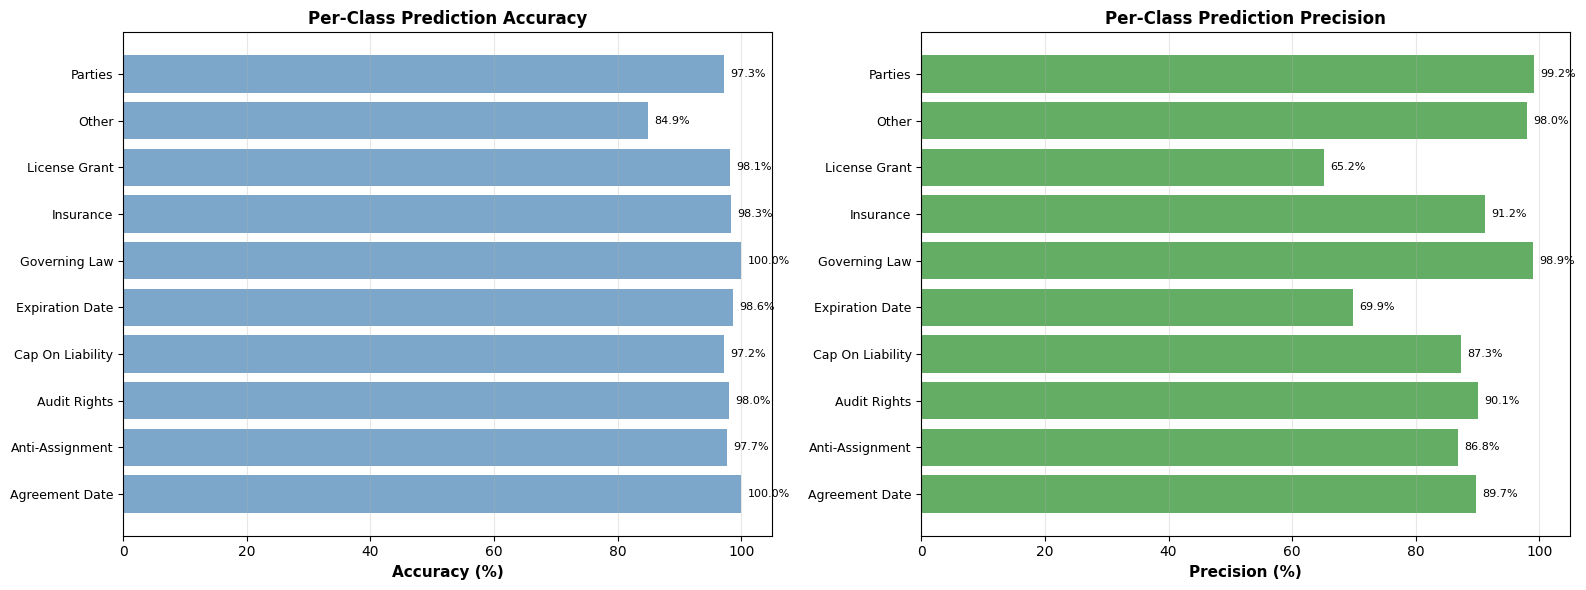


Confusion Matrix:
[[ 87   0   0   0   0   0   0   0   0   0]
 [  0 125   0   0   0   0   0   0   3   0]
 [  0   0 100   0   0   0   0   0   2   0]
 [  0   0   0 103   0   0   0   0   3   0]
 [  0   0   0   0  72   0   0   0   1   0]
 [  0   0   0   0   0  90   0   0   0   0]
 [  0   0   0   0   0   0 114   0   1   1]
 [  0   0   0   0   0   0   0 105   1   1]
 [  9  19  10  15  30   1  10  56 847   1]
 [  1   0   1   0   1   0   1   0   6 355]]


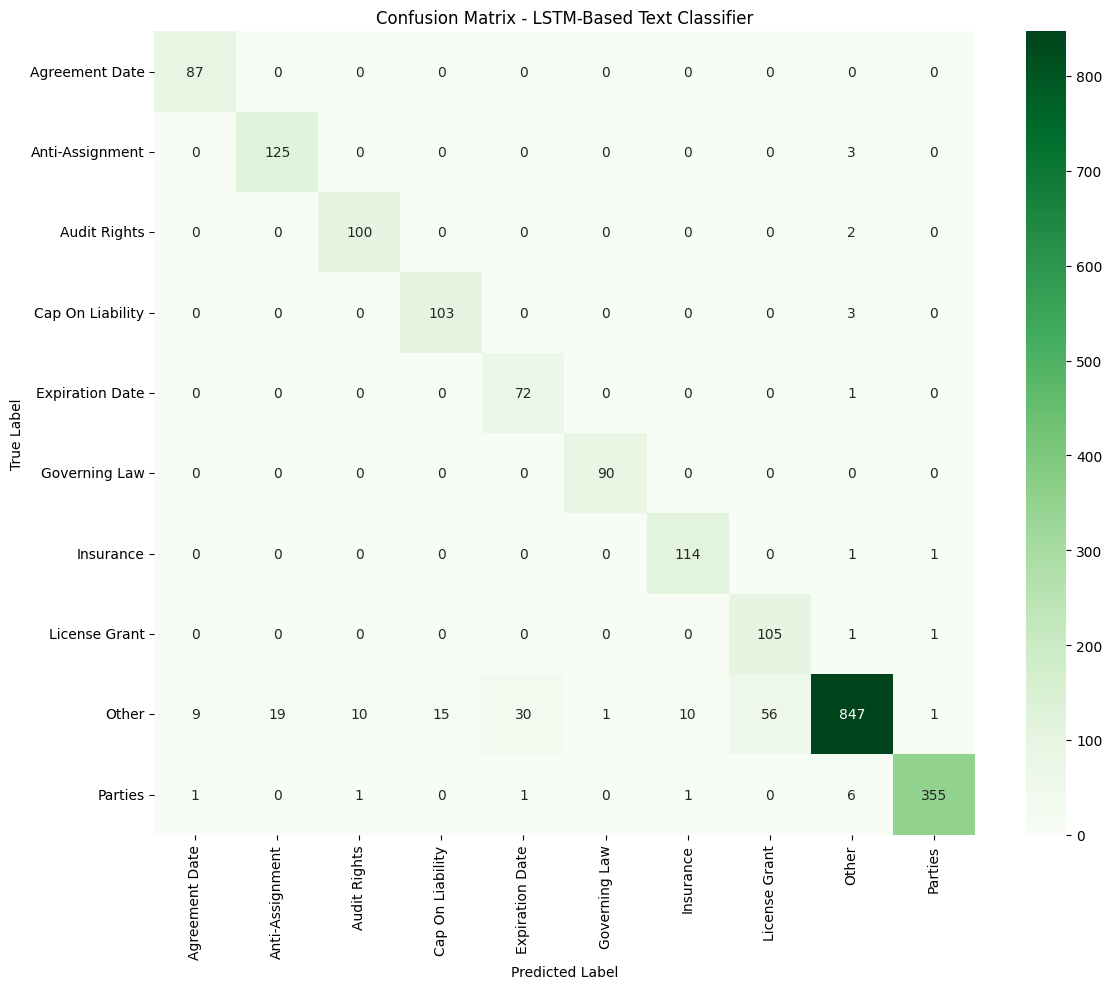

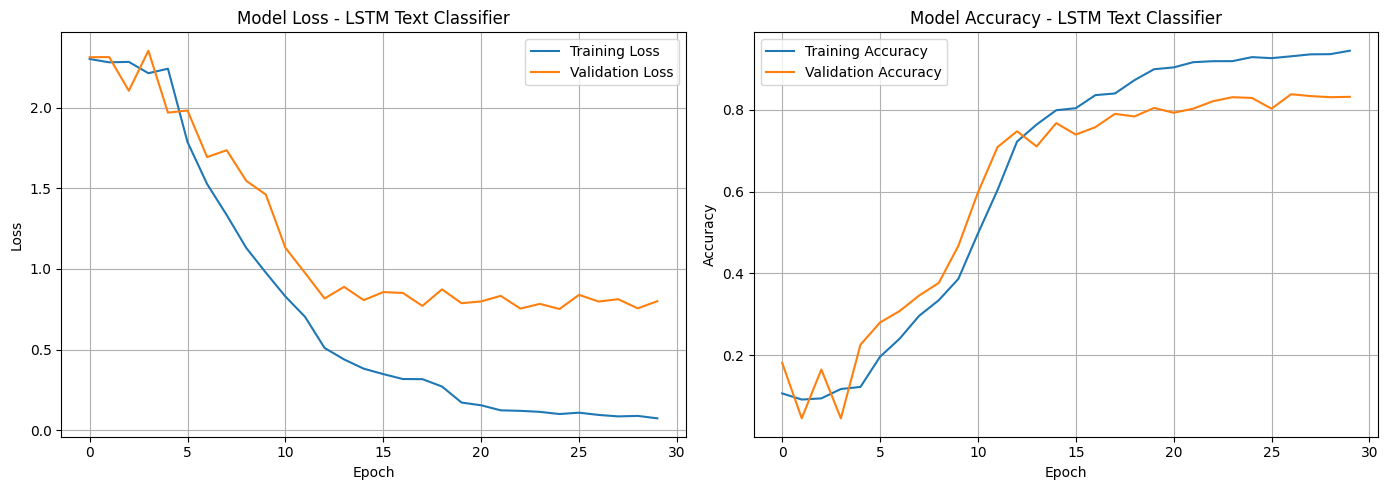

In [44]:
print("EVALUATING LSTM-BASED TEXT CLASSIFIER")

y_pred_lstm = model_lstm.predict(X_test_padded, verbose=0)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test_padded, y_test, verbose=0)

print(f"\nTest Set Performance:")
print(f"  Loss: {test_loss_lstm:.4f}")
print(f"  Accuracy: {test_accuracy_lstm:.4f} ({test_accuracy_lstm*100:.2f}%)")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lstm_classes,
                          target_names=[reverse_label_mapping[i] for i in range(num_classes)]))

precision_lstm = precision_score(y_test, y_pred_lstm_classes, average='weighted', zero_division=0)
recall_lstm = recall_score(y_test, y_pred_lstm_classes, average='weighted', zero_division=0)
f1_lstm = f1_score(y_test, y_pred_lstm_classes, average='weighted', zero_division=0)
f1_macro_lstm = f1_score(y_test, y_pred_lstm_classes, average='macro', zero_division=0)

print(f"\nOverall Metrics:")
print(f"  Precision (weighted): {precision_lstm:.4f}")
print(f"  Recall (weighted): {recall_lstm:.4f}")
print(f"  F1-score (weighted): {f1_lstm:.4f}")
print(f"  F1-score (macro): {f1_macro_lstm:.4f}")

cm_lstm = confusion_matrix(y_test, y_pred_lstm_classes)
precision_per_class_lstm = precision_score(y_test, y_pred_lstm_classes, average=None, zero_division=0)
accuracy_per_class_lstm = cm_lstm.diagonal() / cm_lstm.sum(axis=1)

print(f"\nPer-Class Prediction Accuracy and Precision")
print(f"\n{'Category':<45} {'Test Samples':<15} {'Correct':<12} {'Accuracy %':<15} {'Precision %':<15}")
print("-" * 102)
for i in range(num_classes):
    category_name = reverse_label_mapping[i][:43]
    true_count = int(cm_lstm.sum(axis=1)[i])
    correct_count = int(cm_lstm.diagonal()[i])
    accuracy_pct = accuracy_per_class_lstm[i] * 100
    precision_pct = precision_per_class_lstm[i] * 100
    print(f"{category_name:<45} {true_count:<15} {correct_count:<12} {accuracy_pct:<15.2f} {precision_pct:<15.2f}")

category_names = [reverse_label_mapping[i] for i in range(num_classes)]
accuracy_pct_lstm = accuracy_per_class_lstm * 100
precision_pct_lstm = precision_per_class_lstm * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x_pos = np.arange(len(category_names))

axes[0].barh(x_pos, accuracy_pct_lstm, color='steelblue', alpha=0.7)
axes[0].set_yticks(x_pos)
axes[0].set_yticklabels(category_names, fontsize=9)
axes[0].set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Per-Class Prediction Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlim([0, 105])
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracy_pct_lstm):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

axes[1].barh(x_pos, precision_pct_lstm, color='forestgreen', alpha=0.7)
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(category_names, fontsize=9)
axes[1].set_xlabel('Precision (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Per-Class Prediction Precision', fontsize=12, fontweight='bold')
axes[1].set_xlim([0, 105])
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(precision_pct_lstm):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('Visualizations/lstm_per_class_accuracy_precision.png', bbox_inches='tight', dpi=150)
plt.show()

results_lstm = {
    'model': 'LSTM Text Classifier',
    'test_accuracy': test_accuracy_lstm,
    'test_loss': test_loss_lstm,
    'precision': precision_lstm,
    'recall': recall_lstm,
    'f1_weighted': f1_lstm,
    'f1_macro': f1_macro_lstm
}

print(f"\nConfusion Matrix:")
print(cm_lstm)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
            xticklabels=[reverse_label_mapping[i][:20] for i in range(num_classes)],
            yticklabels=[reverse_label_mapping[i][:20] for i in range(num_classes)])
plt.title('Confusion Matrix - LSTM-Based Text Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('Visualizations/lstm_confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_lstm.history['loss'], label='Training Loss')
axes[0].plot(history_lstm.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss - LSTM Text Classifier')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_lstm.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy - LSTM Text Classifier')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('Visualizations/lstm_training_history.png', bbox_inches='tight', dpi=150)
plt.show()

### 6.3 Model Comparison


MODEL COMPARISON

Performance Comparison:
                   model  test_accuracy  test_loss  precision   recall  f1_weighted  f1_macro
Feedforward MLP (TF-IDF)       0.921731   0.267939   0.938083 0.921731     0.924311  0.916518
    LSTM Text Classifier       0.919890   0.321947   0.934383 0.919890     0.921908  0.915747


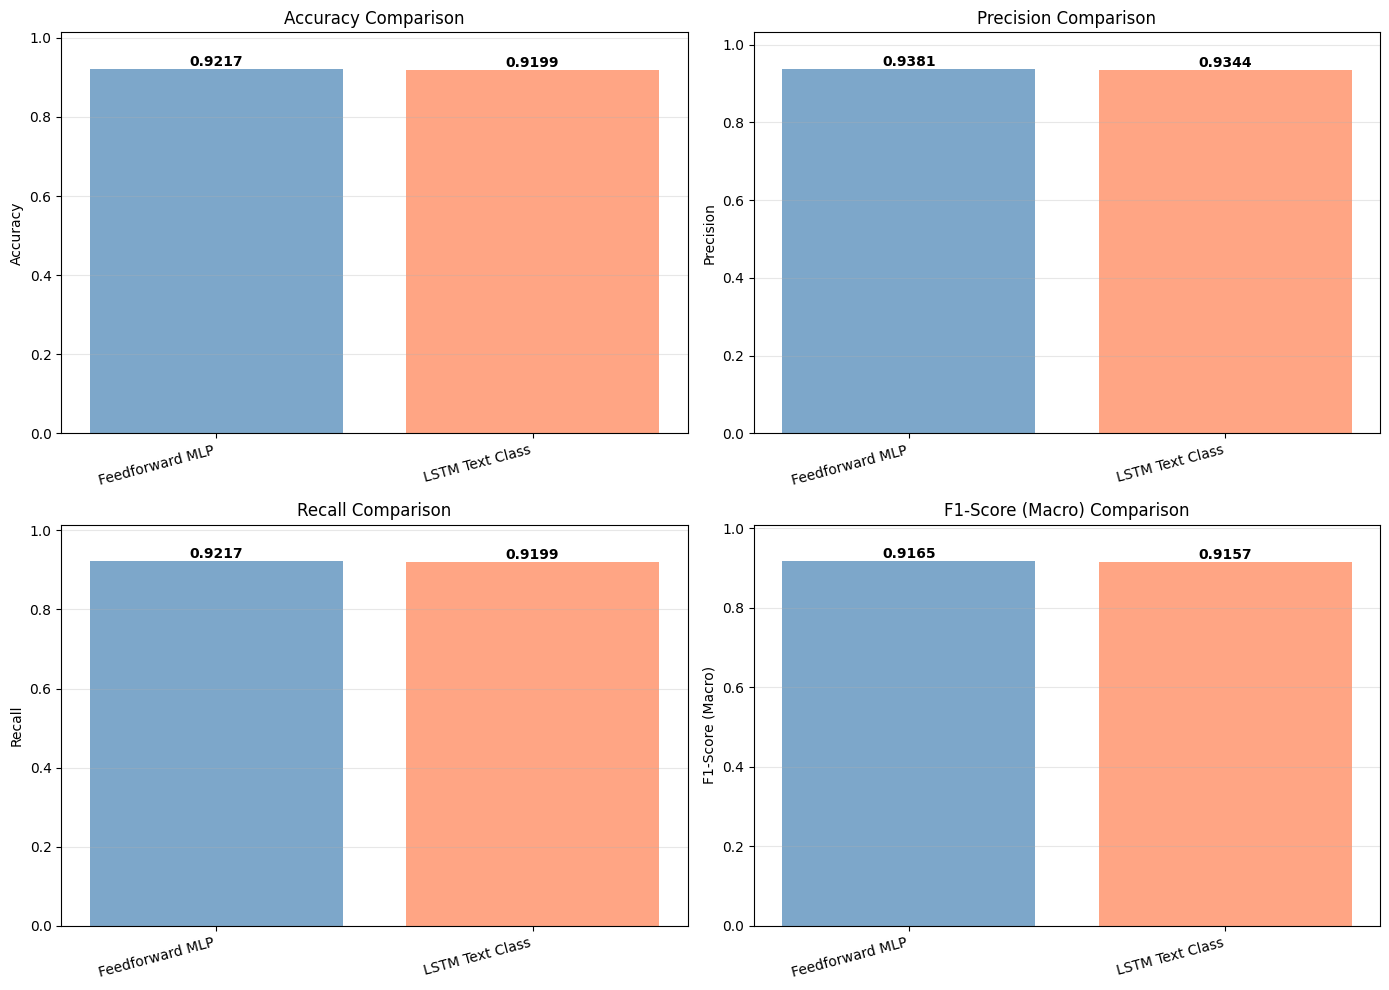


DETAILED COMPARISON TABLE

              Metric Feedforward MLP (TF-IDF) LSTM Text Classifier
       Test Accuracy                   0.9217               0.9199
           Test Loss                   0.2679               0.3219
Precision (Weighted)                   0.9381               0.9344
   Recall (Weighted)                   0.9217               0.9199
 F1-Score (Weighted)                   0.9243               0.9219
    F1-Score (Macro)                   0.9165               0.9157

Best Model (by Macro F1-Score): Feedforward MLP (TF-IDF)
  Improvement: 0.08%


In [45]:
print("MODEL COMPARISON")

comparison_df = pd.DataFrame([results_ff, results_lstm])

print("\nPerformance Comparison:")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_compare = ['test_accuracy', 'precision', 'recall', 'f1_macro']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score (Macro)']

for idx, (metric, label) in enumerate(zip(metrics_to_compare, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    models = comparison_df['model'].values
    values = comparison_df[metric].values

    bars = ax.bar(models, values, color=['steelblue', 'coral'], alpha=0.7)
    ax.set_ylabel(label)
    ax.set_title(f'{label} Comparison')
    ax.set_ylim(0, max(values) * 1.1)
    ax.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

    ax.set_xticklabels([m[:15] for m in models], rotation=15, ha='right')

plt.tight_layout()
plt.savefig('Visualizations/model_comparison.png', bbox_inches='tight', dpi=150)
plt.show()


print("\nDETAILED COMPARISON TABLE")

comparison_table = pd.DataFrame({
    'Metric': ['Test Accuracy', 'Test Loss', 'Precision (Weighted)',
               'Recall (Weighted)', 'F1-Score (Weighted)', 'F1-Score (Macro)'],
    'Feedforward MLP (TF-IDF)': [
        f"{results_ff['test_accuracy']:.4f}",
        f"{results_ff['test_loss']:.4f}",
        f"{results_ff['precision']:.4f}",
        f"{results_ff['recall']:.4f}",
        f"{results_ff['f1_weighted']:.4f}",
        f"{results_ff['f1_macro']:.4f}"
    ],
    'LSTM Text Classifier': [
        f"{results_lstm['test_accuracy']:.4f}",
        f"{results_lstm['test_loss']:.4f}",
        f"{results_lstm['precision']:.4f}",
        f"{results_lstm['recall']:.4f}",
        f"{results_lstm['f1_weighted']:.4f}",
        f"{results_lstm['f1_macro']:.4f}"
    ]
})

print("\n" + comparison_table.to_string(index=False))

if results_ff['f1_macro'] > results_lstm['f1_macro']:
    winner = "Feedforward MLP (TF-IDF)"
    improvement = ((results_ff['f1_macro'] - results_lstm['f1_macro']) / results_lstm['f1_macro']) * 100
else:
    winner = "LSTM Text Classifier"
    improvement = ((results_lstm['f1_macro'] - results_ff['f1_macro']) / results_ff['f1_macro']) * 100

print(f"\nBest Model (by Macro F1-Score): {winner}")
print(f"  Improvement: {improvement:.2f}%")

add a plot for each class cetegory classification
work on embedding
